
### Hospital and ACSPopulation: Fairness & Repair Exploratory Analysis - Kushagra Ghosh

In data cleaning, the objective is to ensure that data can adhere to the right quality and integrity constraints. Our data has constraints (functional dependencies or FDs) that we want the database to satisfy (such as Zip Code -> City, State). There are countless algorithms for data repair that take in data and delete tuples, change values, or add different tuples to satisfy FDs using ML and statistics about the data. However, by changing the data, these repair algorithms may hurt one population. For example, by deleting a higher proportion of female tuples, there may be a lower percentage of females in the final data, swaying our statistics and create bias. We would like to verify our assumption that data repair algorithms can introduce bias. 

The idea of this exploration exercise is to see how query answers differ after specific data transformations. Specifically, does the data become distorted due to these transformations and then may lead the analyst to the wrong conclusion due to bias? 

My first step was to retrive the dataset I am working with. Folktale is a package with various datasets, each with different tables and tasks to be predicted. I read the instructions and installed the package to work with the population dataset from here: https://github.com/zykls/folktables. This population dataset is from the American Community Survey Public Use Microdata Sample from https://www.census.gov/programs-surveys/acs/microdata/documentation.html.

In [1]:
%%capture
pip install folktables

In [6]:
from folktables import ACSDataSource, ACSIncome
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


I generated a uniform random sample from each state with approximately 50% or 40% percentage for sex, and representation for different protected subpopulations (such as different races).

In [7]:
%%capture
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
us_data = data_source.get_data(density=0.01,download=True)
#us_data = us_data.iloc[:,:130]

I also varied the density and random seed of my sampling from the US population dataset to see if I would also get a consistent distribution. From here on, I will be using the Sample 1 (us_data) since I do get a consistent distribution.

In [8]:
#Varying the density and the random seed
us_data2 = data_source.get_data(density=0.002,random_seed=12,download=True)

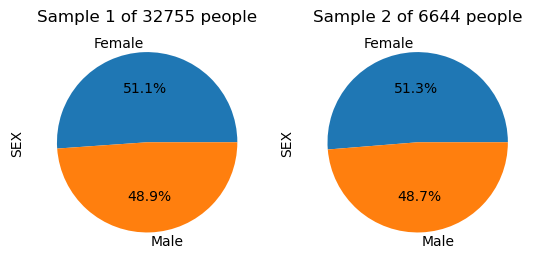

In [9]:
plt.subplot(1, 2, 1)
sex_label_mapping = {1: 'Male', 2: 'Female'}
sex_labels = us_data['SEX'].value_counts().keys()
us_data['SEX'].value_counts().plot(kind="pie", labels =[sex_label_mapping[l] for l in sex_labels], autopct='%1.1f%%')
plt.title("Sample 1 of {} people".format(us_data.shape[0]))
plt.subplot(1, 2, 2)
sex_labels = us_data2['SEX'].value_counts().keys()
us_data2['SEX'].value_counts().plot(kind="pie", labels =[sex_label_mapping[l] for l in sex_labels], autopct='%1.1f%%')
plt.title("Sample 2 of {} people".format(us_data2.shape[0]))
plt.show()

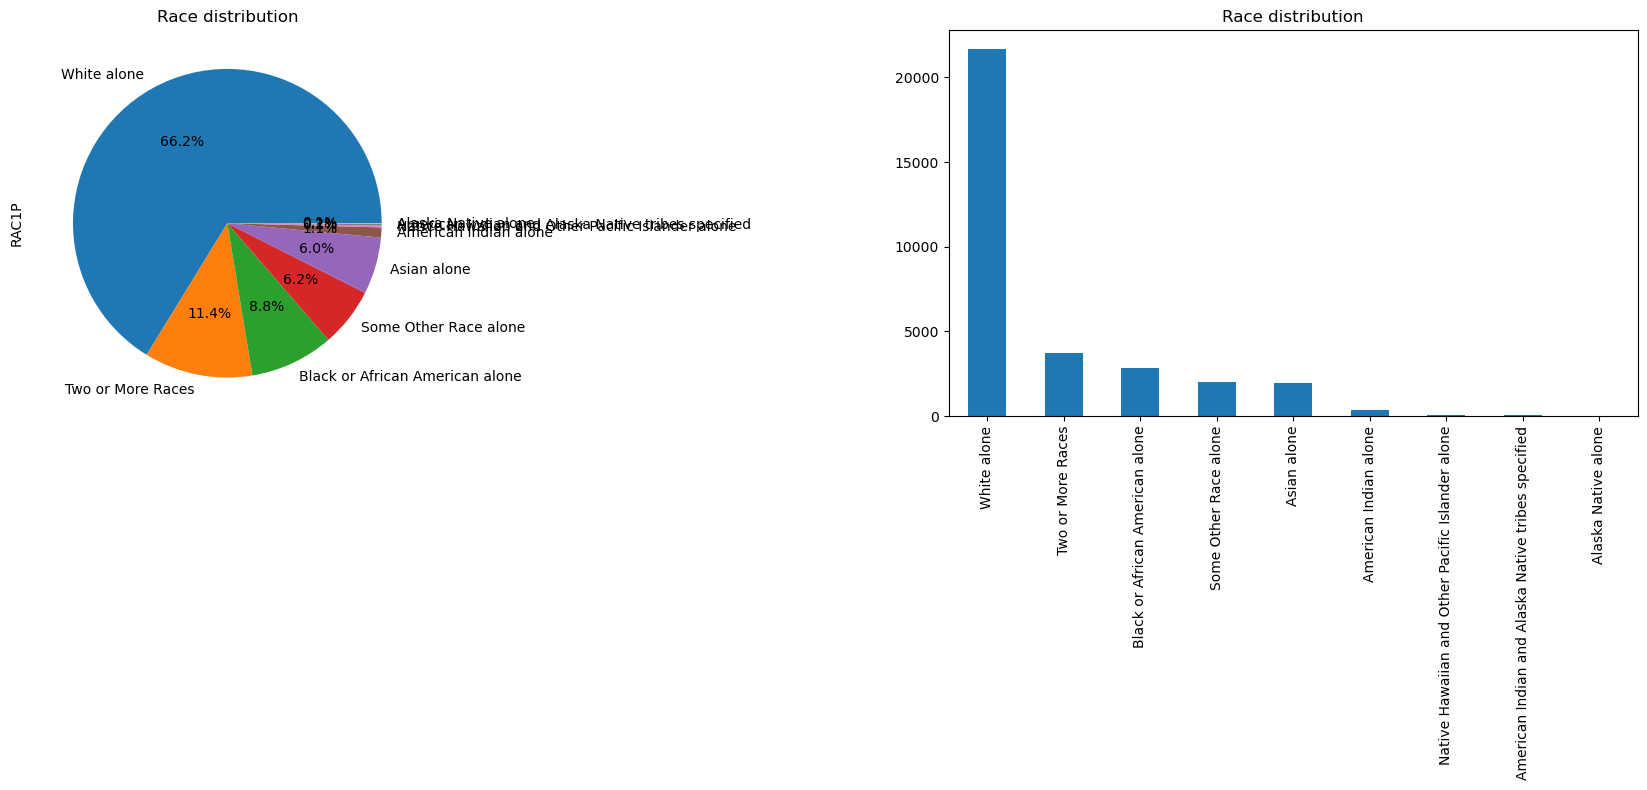

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
race_label_mapping = {1: 'White alone', 2: 'Black or African American alone', 3: 'American Indian alone', 4: 'Alaska Native alone', 5: 'American Indian and Alaska Native tribes specified', 6: 'Asian alone', 7: 'Native Hawaiian and Other Pacific Islander alone', 8: 'Some Other Race alone', 9: 'Two or More Races'}
race_labels = us_data['RAC1P'].value_counts().keys()
us_data['RAC1P'].value_counts().plot(kind="pie", labels =[race_label_mapping[l] for l in race_labels], autopct='%1.1f%%', ax=ax1)
ax1.set_title("Race distribution")

us_data['RAC1P'].value_counts().plot.bar(ax=ax2)
ax2.set_xticks(range(len(race_labels)), [race_label_mapping[l] for l in race_labels])
ax2.set_title("Race distribution")
plt.tight_layout()
plt.show()

I computed the average income for the entire population and for different protected subpopulations (different sexes, different races). 


In [11]:
avg_income = np.mean(us_data['PINCP'])
print("Average income for the sample: ${:.2f}".format(avg_income))

Average income for the sample: $45093.63


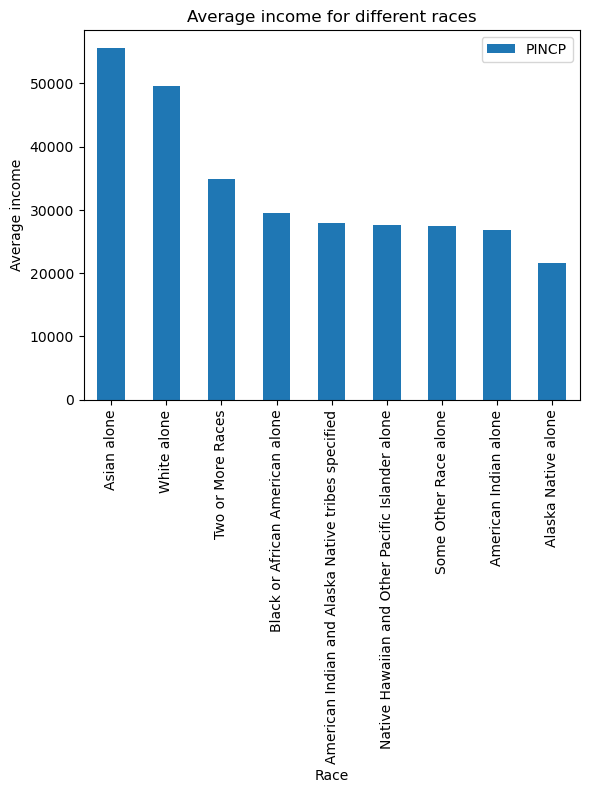

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_4708/3337340843.py:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(race_income.style.hide_index())


Race,PINCP
Asian alone,55641.925746
White alone,49618.607150
Two or More Races,34931.299028
Black or African American alone,29455.528099
American Indian and Alaska Native tribes specified,27867.659574
Native Hawaiian and Other Pacific Islander alone,27642.142857
Some Other Race alone,27483.223844
American Indian alone,26766.037175
Alaska Native alone,21656.875000


In [12]:
race_income = us_data.pivot_table(values='PINCP', index='RAC1P', aggfunc='mean').sort_values(ascending=False, by='PINCP')
race_income_labels = list(race_income.index.values)
race_income.plot.bar()
plt.xticks(range(len(race_income_labels)), [race_label_mapping[l] for l in race_income_labels])
plt.title("Average income for different races")
plt.xlabel("Race")
plt.ylabel("Average income")
plt.show()

race_income.insert(0, 'Race', race_income.index)
race_income['Race'] = race_income['Race'].replace(race_label_mapping)
display(race_income.style.hide_index())

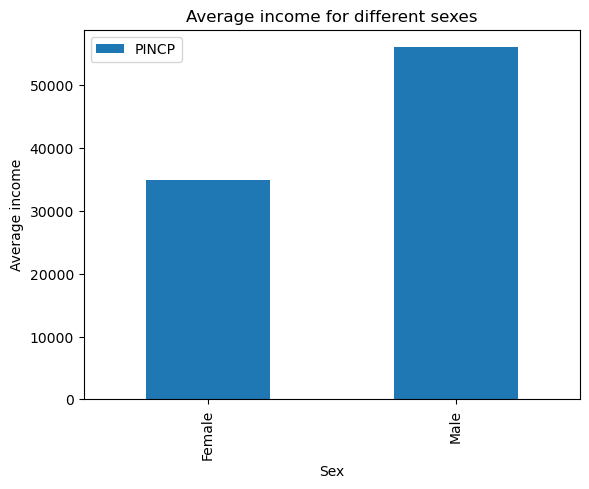

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_4708/955699751.py:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(sexes_income.style.hide_index())


Sex,PINCP
Female,34852.283188
Male,56017.125730


In [13]:
sexes_income = us_data.pivot_table(values='PINCP', index='SEX', aggfunc='mean').sort_values(ascending=False, by='SEX')
sex_income_labels = list(sexes_income.index.values)
sexes_income.plot.bar()
plt.xticks(range(len(sex_income_labels)), [sex_label_mapping[l] for l in sex_income_labels])
plt.title("Average income for different sexes")
plt.xlabel("Sex")
plt.ylabel("Average income")
plt.show()

sexes_income.insert(0, 'Sex', sexes_income.index)
sexes_income['Sex'] = sexes_income['Sex'].replace(sex_label_mapping)
display(sexes_income.style.hide_index())

Then, I found a functional dependency (FD) that is satisfied by the data, e.g., zipCode -> PUMA in each state. I verified that the FD makes sense and that the data doesn't violate the known FD it before moving to the next step. 

In [14]:
print(us_data.groupby(['ST'])['REGION'].nunique().eq(1).all())
print(us_data.groupby(['YOEP'])['DECADE'].nunique().eq(1).all())

print(us_data2.groupby(['ST'])['REGION'].nunique().eq(1).all())
print(us_data2.groupby(['YOEP'])['DECADE'].nunique().eq(1).all())

True
True
True
True


Then, I will generate synthetic data (with a machine learning model), which changes the values of the tuple but maintains the same number of tuples. With my new synthetic ACS person data, I will check how many violations of the Functional Dependencies I find, and how the various marginal distributions for income based on race, gender, region, and more is affected.

In [15]:
%%capture
pip install sdv

For the first synthetic data being generated from the original data (us_data), I decided to only use metadata about the numerical or categorical type of each attribute, and chose to specifically omit constraints such as the FixedConstraints (which is as close to Denial Constraints as the SDV package offers). I will add these constraints in my later synthetic data generators that use the original data (us_data) and several constraints I can observe in the data.

In [16]:
metadata = {
    'fields': {},
    'constraints': [],
    'primary_key': 'SERIALNO'
}

import requests, csv

url = 'https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2021.csv'
response = requests.get(url)

if response.status_code == 200:
    # Save the content of the response (CSV data) to a file
    with open('PUMS_Data_Dictionary_2021.csv', 'wb') as f:
        f.write(response.content)
else:
    print('Failed to download CSV file')

# Open the CSV file for reading
with open('PUMS_Data_Dictionary_2021.csv', 'r') as f:
    reader = csv.reader(f)
    count = 0;
    for row in reader:
        if row[0]=='NAME' and row[1]=='RT':
            count+=1
        if row[0]=='NAME' and count==2:
            metadata['fields'][row[1]] = {'type': 'categorical'} if row[2]=='C' else {'type': 'numerical', 'subtype': 'integer'}

#print(metadata['fields'])

I experimented with using several synthetic data generators (from the Synthetic Data Vault package found at https://sdv.dev/SDV/index.html) using various Copulas and Deep Learning based models. Finally, I used the TabularPreset model from https://sdv.dev/SDV/user_guides/single_table/tabular_preset.html to generate synthetic data from the original data (us_data) due to its quicker runtime and more accurate distributions compared to the original dataset. 

In [17]:
#Working using GaussianCopula 
#from sdv.tabular import CTGAN, GaussianCopula
# model = GaussianCopula(primary_key='SERIALNO')
# model.fit(us_data)

#us_data_training = data_source.get_data(density=0.0002,download=True)
#us_data_training = us_data.iloc[:, :130]
#us_data_training.fillna(0, inplace=True)
#model = CTGAN(primary_key='SERIALNO', epochs=10, batch_size=10)

#us_data.fillna(0, inplace=True)

# from sdv.tabular import TVAE
# model = TVAE(primary_key='SERIALNO')
# model.fit(us_data)

# from sdv.tabular import GaussianCopula
# model = GaussianCopula(primary_key='SERIALNO')
# model.fit(us_data)

# from sdv.tabular import CopulaGAN
# model = CopulaGAN()
# model.fit(us_data)

from sdv.lite import TabularPreset
model = TabularPreset(name='FAST_ML', metadata=metadata)
model.fit(us_data)

The size of the generated data matches the size of the initial data.

In [18]:
new_data = model.sample(num_rows=us_data.shape[0])
display(new_data)

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,a,6,2,1101,4,49,1029928,44,44,...,0,13,97,68,-5,103,97,24,116,101
1,P,b,9,4,307,2,17,1029928,117,6,...,148,202,199,224,119,27,85,95,74,50
2,P,c,3,2,700,2,34,1029928,76,33,...,95,198,71,58,71,28,75,117,2,165
3,P,d,7,3,900,1,29,1029928,80,36,...,21,-4,63,56,70,0,0,94,32,77
4,P,e,9,3,2902,3,48,1029928,149,53,...,144,150,173,158,123,94,74,232,243,319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32750,P,leQ,2,3,3715,3,37,1029928,102,5,...,123,170,47,96,203,170,151,53,115,147
32751,P,leR,2,2,1203,4,21,1029928,115,34,...,185,128,29,165,70,132,38,14,133,121
32752,P,leS,0,2,500,4,56,1029928,77,43,...,87,73,77,202,105,46,0,118,91,107
32753,P,leT,9,1,1207,2,48,1029928,186,87,...,173,185,213,153,196,251,172,193,257,180


I added the primary_key argument to the model and checked to ensure that the SERIALNO column is a primary key by checking for its uniqueness in the synthetic data.

In [19]:
unique_count_of_primary_key = us_data['SERIALNO'].nunique()
total_count_of_primary_key = us_data.shape[0]
print('SERIALNO is a primary key for the original us_data training dataset: {}'.format(unique_count_of_primary_key == total_count_of_primary_key))
print('Number of rows with a nonunique value of SERIALNO: {}\n'.format(total_count_of_primary_key-unique_count_of_primary_key))

unique_count = new_data['SERIALNO'].nunique()
total_count = new_data.shape[0]
print('SERIALNO is a primary key for the generated synthetic data: {}'.format(unique_count == total_count))

SERIALNO is a primary key for the original us_data training dataset: False
Number of rows with a nonunique value of SERIALNO: 341

SERIALNO is a primary key for the generated synthetic data: True


Then, I checked if the generated data satisfies the functional dependency. I check if two columns form a FD by comparing the values at both columns for each tuple and checking if one column uniquely determined the other column. 

Given two columns ST and REGION, the approach I implemented is to first group by the values of the ST column and use the nunique() method to check number of unique values in REGION for each group in the ST column. If all of the values are 1, that means that there is a unique value for REGION for each each value in ST, which means that columns ST and REGION conform to a functional dependency.

In [20]:
fd1_training = us_data.groupby(['ST'])['REGION'].nunique().eq(1).all()
fd1_new = new_data.groupby(['ST'])['REGION'].nunique().eq(1).all()
print("For the functional dependency between State -> US Region:")
print(f"The us_data original dataset satisfies FD: {fd1_training}\nThe generated synthetic data satisfies FD: {fd1_new}")

fd2_training = us_data.groupby(['YOEP'])['DECADE'].nunique().eq(1).all()
fd2_new = new_data.groupby(['YOEP'])['DECADE'].nunique().eq(1).all()
print("\nFor the functional dependency between Year of Entry in US -> Decade of Entry in US:")
print(f"The us_data original dataset satisfies FD: {fd2_training}\nThe generated synthetic data satisfies FD: {fd2_new}")

For the functional dependency between State -> US Region:
The us_data original dataset satisfies FD: True
The generated synthetic data satisfies FD: False

For the functional dependency between Year of Entry in US -> Decade of Entry in US:
The us_data original dataset satisfies FD: True
The generated synthetic data satisfies FD: False


I also checked how many violations of the FDs are in the data. (i.e., how many pairs of tuples violate it) to quantify how noisy the new synthetic data is. In order to do this, I did a projection on my dataframe to get the relevant columns for the FD, and then I did a self join query with the column in the left side of the FD being equal but the column in the right side of the FD being not equal (for example for State -> Region, I set the join condition as A.State = B.State and A.Region != B.Region). 

Then I counted how many tuples form a violation the new merged table, and divided this number by the maximum number of ways of joining two tuples together. This number is equal to the maximum number of violations possible in the new merge table, which turns out to be $tuples\space in \space original \space dataframe \choose 2$ . 

In [21]:
import math

merging_data = new_data[['SERIALNO', 'ST', 'REGION']]
num_rows = merging_data.shape[0]
maxViolations = math.comb(num_rows,2)

result = pd.merge(merging_data, merging_data, how='inner', left_on=['ST'], right_on=['ST'], suffixes=('_left', '_right'))
result = result[result['SERIALNO_left'] > result['SERIALNO_right']]
result = result[result['REGION_left'] != result['REGION_right']]
num_violations = result.shape[0]
print(f"{num_violations} pairs of tuples violate the ST -> REGION FD. The maximum possible violations are {maxViolations}. The percentage is {num_violations/maxViolations:.3%}")

16561788 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 3.087%


Then, I repeated my earlier step for the new synthetic data generated: I recomputed the average income for the entire population and for different protected subpopulations (different sexes, different races).  

In [22]:
avg_income_training = np.mean(us_data['PINCP'])
print("Average income for the us_data training data: ${:.2f}".format(avg_income_training))
avg_income_new = np.mean(new_data['PINCP'])
print("Average income for the new synthetic data: ${:.2f}".format(avg_income_new))

Average income for the us_data training data: $45093.63
Average income for the new synthetic data: $51992.20


I compared the marginal distributions of average income from the original data and the synthetic data. First, I compared the race distributions (counts) in original data (us_data) and new synthetic data (new_data).

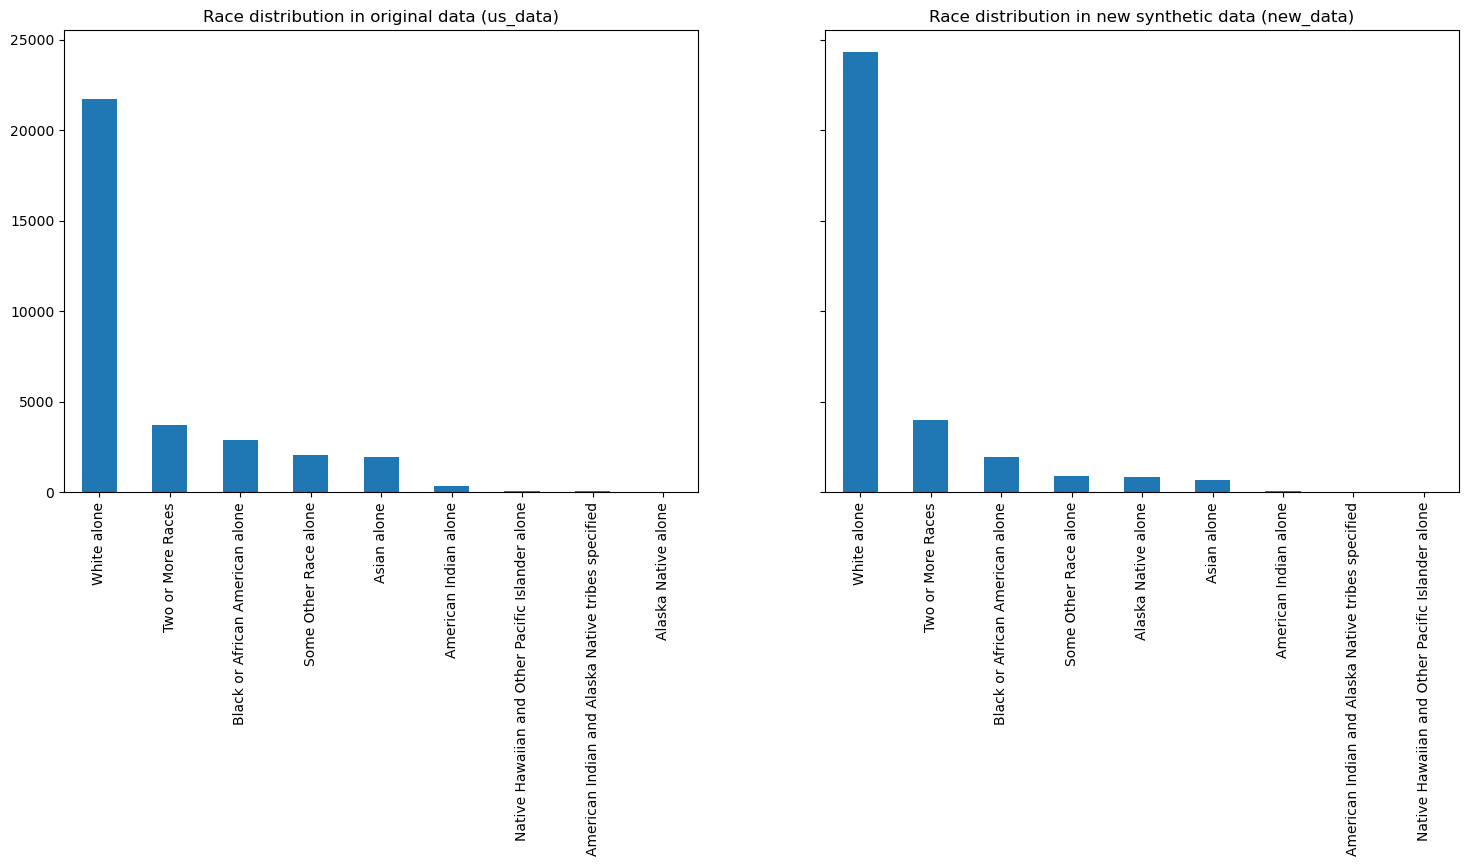

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), sharey=True)
us_data['RAC1P'].value_counts().plot.bar(ax=ax1)
ax1.set_xticks(range(len(race_labels)), [race_label_mapping[l] for l in race_labels])
ax1.set_title("Race distribution in original data (us_data)")

new_data['RAC1P'].value_counts().plot.bar(ax=ax2)
new_race_labels = new_data['RAC1P'].value_counts().keys()
ax2.set_xticks(range(len(new_race_labels)), [race_label_mapping[l] for l in new_race_labels])
ax2.set_title("Race distribution in new synthetic data (new_data)")
plt.show()

# us_data['RAC1P'].value_counts().plot(kind="pie", labels =[race_label_mapping[l] for l in race_labels], autopct='%1.1f%%', ax=ax1)
# ax1.set_title("Race distribution")

I compared the average income for different races in original data (us_data) and new synthetic data (new_data).

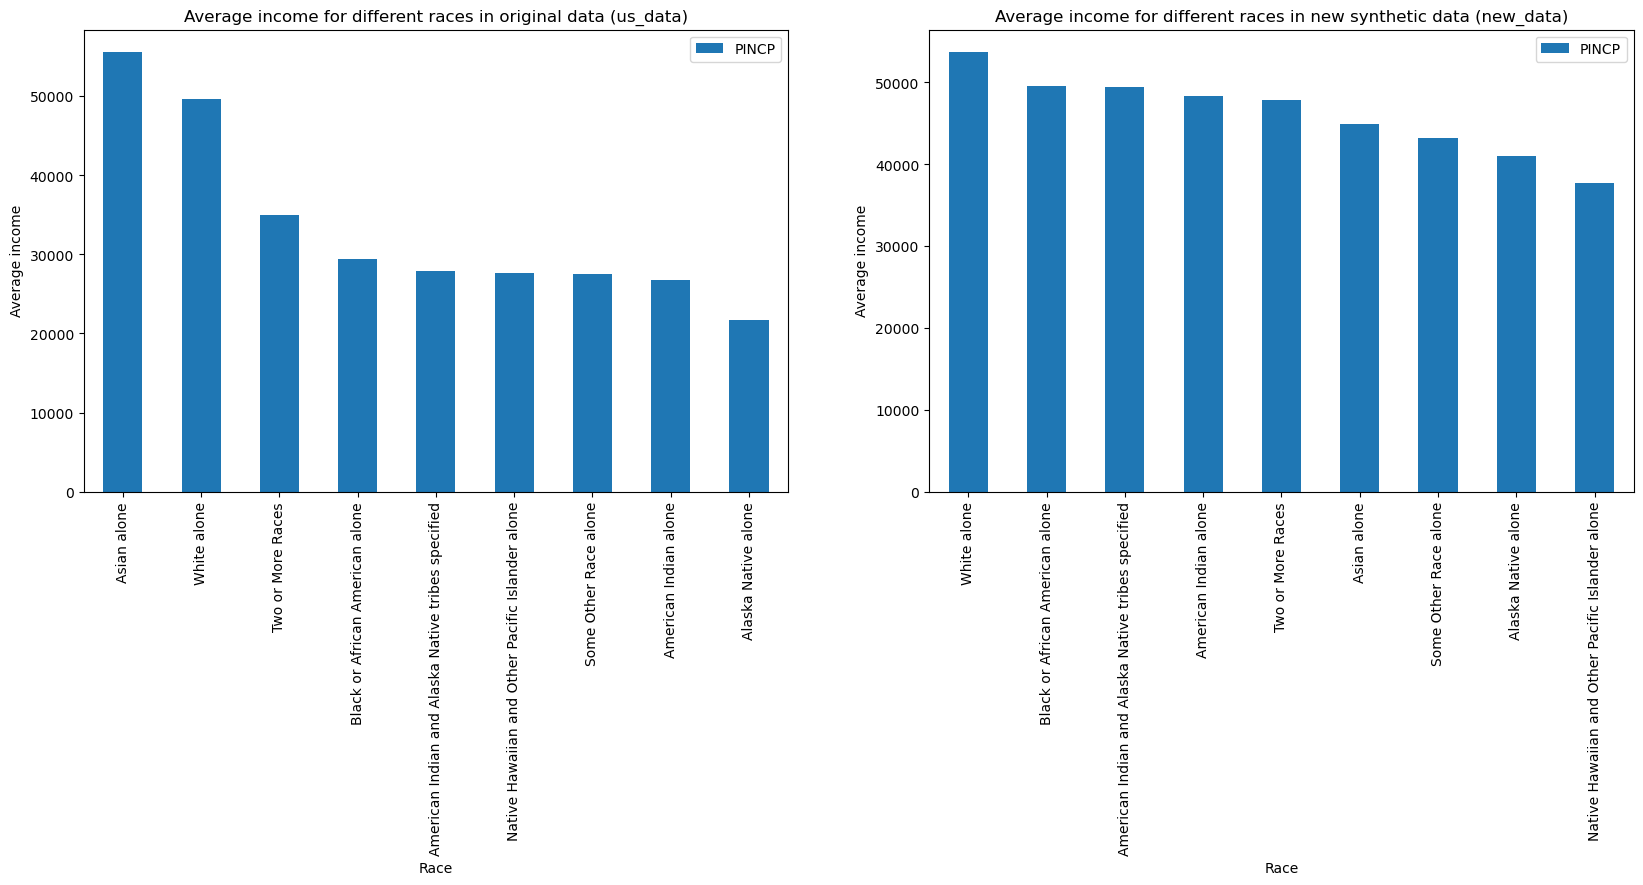

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
race_income.plot.bar(ax=ax1)
ax1.set_xticks(range(len(race_labels)), [race_label_mapping[l] for l in race_income_labels])
ax1.set_title("Average income for different races in original data (us_data)")
ax1.set_xlabel("Race")
ax1.set_ylabel("Average income")

race_income_new = new_data.pivot_table(values='PINCP', index='RAC1P', aggfunc='mean').sort_values(ascending=False, by='PINCP')
race_income_new_labels = list(race_income_new.index.values)
race_income_new.plot.bar(ax=ax2)
ax2.set_xticks(range(len(race_income_new_labels)), [race_label_mapping[l] for l in race_income_new_labels])
ax2.set_title("Average income for different races in new synthetic data (new_data)")
ax2.set_xlabel("Race")
ax2.set_ylabel("Average income")

plt.show()

I compared the sex distributions in original data (us_data) and new synthetic data (new_data)

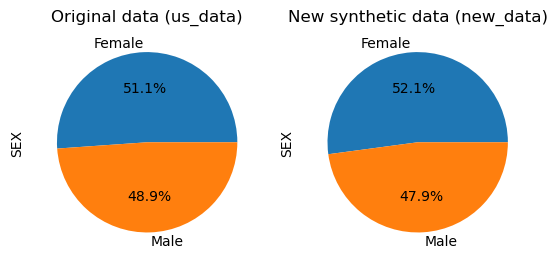

In [25]:
plt.subplot(1, 2, 1)
original_sex_labels = us_data['SEX'].value_counts().keys()
us_data['SEX'].value_counts().plot(kind="pie", labels =[sex_label_mapping[l] for l in original_sex_labels], autopct='%1.1f%%')
plt.title("Original data (us_data)")
plt.subplot(1, 2, 2)
new_sex_labels = new_data['SEX'].value_counts().keys()
new_data['SEX'].value_counts().plot(kind="pie", labels =[sex_label_mapping[l] for l in new_sex_labels], autopct='%1.1f%%')
plt.title("New synthetic data (new_data)")
plt.show()

I compared the average income for different sexes in original data (us_data) and new synthetic data (new_data)

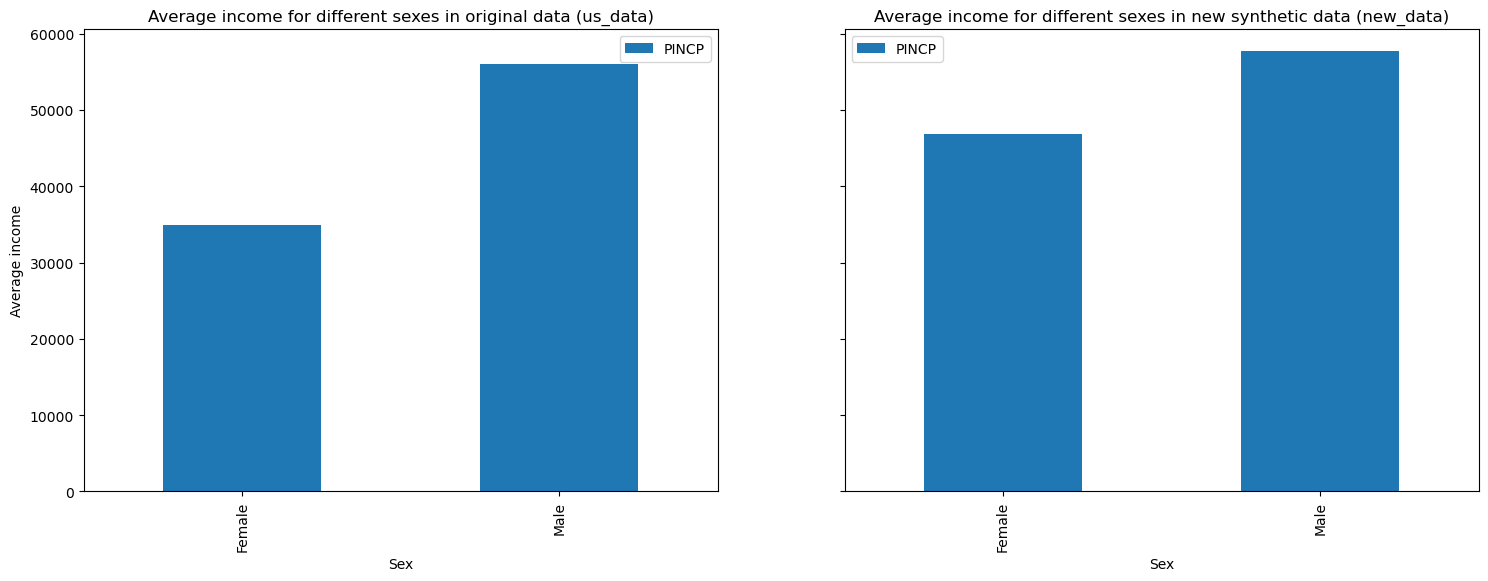

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), sharey=True)
sexes_income.plot.bar(ax=ax1)
ax1.set_xticks(range(len(sex_income_labels)), [sex_label_mapping[l] for l in sex_income_labels])
ax1.set_title("Average income for different sexes in original data (us_data)")
ax1.set_xlabel("Sex")
ax1.set_ylabel("Average income")

sexes_income_new = new_data.pivot_table(values='PINCP', index='SEX', aggfunc='mean').sort_values(ascending=False, by='SEX')
new_sex_income_labels = list(sexes_income_new.index.values)
sexes_income_new.plot.bar(ax=ax2)
ax2.set_xticks(range(len(new_sex_income_labels)), [sex_label_mapping[l] for l in new_sex_income_labels])
ax2.set_title("Average income for different sexes in new synthetic data (new_data)")
ax2.set_xlabel("Sex")
ax2.set_ylabel("Average income")

plt.show()

I compared the region distributions (counts) in original data (us_data) and new synthetic data (new_data)

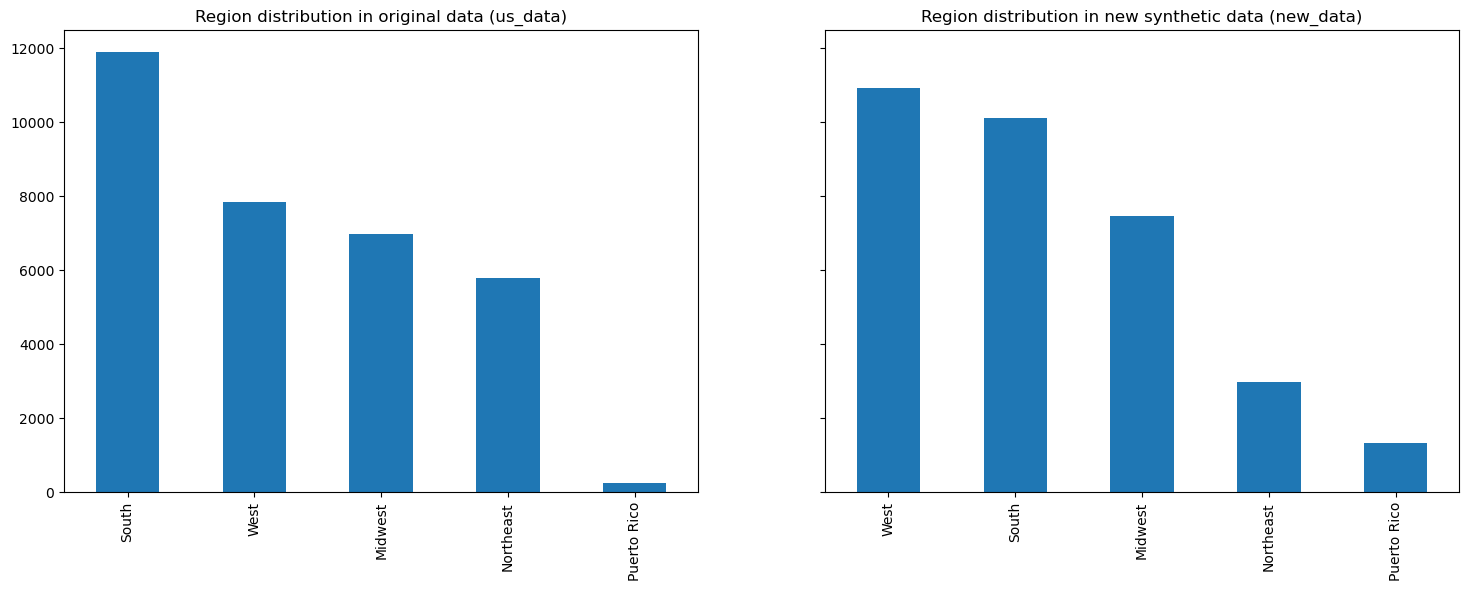

In [27]:
# plt.subplot(1, 2, 1)
# original_region_labels = us_data['REGION'].value_counts().keys()
# us_data['REGION'].value_counts().plot(kind="pie", labels =[region_label_mapping[l] for l in original_region_labels], autopct='%1.1f%%')
# plt.title("Original data (us_data)")
# plt.subplot(1, 2, 2)
# new_region_labels = new_data['REGION'].value_counts().keys()
# new_data['REGION'].value_counts().plot(kind="pie", labels =[l if l not in region_label_mapping else region_label_mapping[l] for l in new_region_labels], autopct='%1.1f%%')
# plt.title("New synthetic data (new_data)")
# plt.show()
region_label_mapping = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West', 9: 'Puerto Rico'}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), sharey=True)
us_data['REGION'].value_counts().plot.bar(ax=ax1)
original_region_labels = us_data['REGION'].value_counts().keys()
ax1.set_xticks(range(len(original_region_labels)), [region_label_mapping[l] for l in original_region_labels])
ax1.set_title("Region distribution in original data (us_data)")

new_data['REGION'].value_counts().plot.bar(ax=ax2)
new_region_labels = new_data['REGION'].value_counts().keys()
ax2.set_xticks(range(len(new_region_labels)), [l if l not in region_label_mapping else region_label_mapping[l] for l in new_region_labels])
ax2.set_title("Region distribution in new synthetic data (new_data)")
plt.show()

I compared the average income for different regions in original data (us_data) and new synthetic data (new_data)

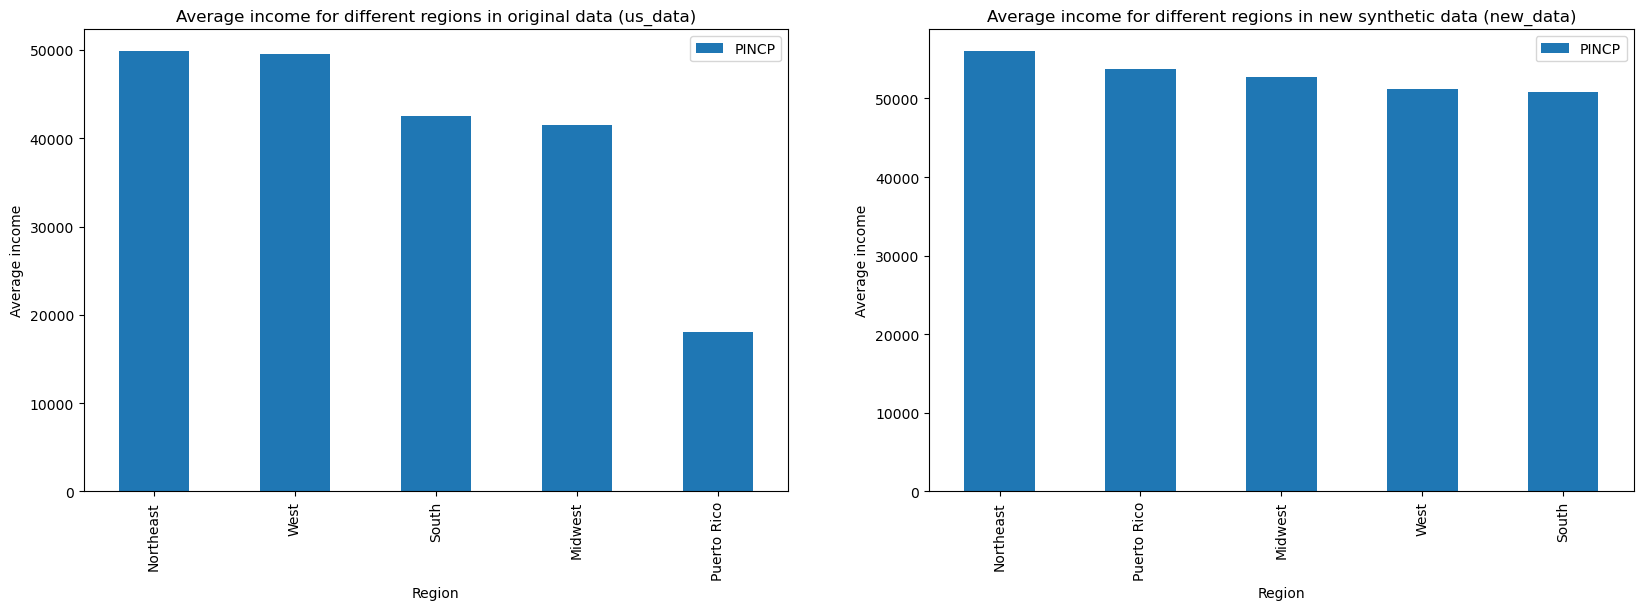

Region categories in original data: {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West', 9: 'Puerto Rico'}
Region categories in synthetic data: [1, 9, 2, 4, 3]


In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
region_income = us_data.pivot_table(values='PINCP', index='REGION', aggfunc='mean').sort_values(ascending=False, by='PINCP')
region_income_labels = list(region_income.index.values)
region_income.plot.bar(ax=ax1)
ax1.set_xticks(range(len(region_income_labels)), [region_label_mapping[l] for l in region_income_labels])
ax1.set_title("Average income for different regions in original data (us_data)")
ax1.set_xlabel("Region")
ax1.set_ylabel("Average income")

region_income_new = new_data.pivot_table(values='PINCP', index='REGION', aggfunc='mean').sort_values(ascending=False, by='PINCP')
new_region_income_labels = list(region_income_new.index.values)
region_income_new.plot.bar(ax=ax2)
ax2.set_xticks(range(len(new_region_income_labels)), [l if l not in region_label_mapping else region_label_mapping[l] for l in new_region_income_labels])
ax2.set_title("Average income for different regions in new synthetic data (new_data)")
ax2.set_xlabel("Region")
ax2.set_ylabel("Average income")

plt.show()

print(f"Region categories in original data: {region_label_mapping}")
print(f"Region categories in synthetic data: {new_region_income_labels}")


Afterwards, I compared the original data and synthetic data further by comparing the percent of females earning above 50k, percent of males earning above 50k, and percent of southerners earning above 50k. 

In [29]:
female_original = us_data[us_data['SEX']==2]
female_original_above50k = female_original.loc[female_original['PINCP'] > 50000]
female_synthetic = new_data[new_data['SEX']==2]
female_synthetic_above50k = female_synthetic.loc[female_synthetic['PINCP'] > 50000]

print(f"Percent of females earning above 50k in original data (us_data): {female_original_above50k.shape[0]}/{female_original.shape[0]} = {female_original_above50k.shape[0]/female_original.shape[0]:.3%}")
print(f"Percent of females earning above 50k in synthetic data (new_data): {female_synthetic_above50k.shape[0]}/{female_synthetic.shape[0]} = {female_synthetic_above50k.shape[0]/female_synthetic.shape[0]:.3%}")

Percent of females earning above 50k in original data (us_data): 3064/16742 = 18.301%
Percent of females earning above 50k in synthetic data (new_data): 5229/17071 = 30.631%


In [30]:
male_original = us_data[us_data['SEX']==1]
male_original_above50k = male_original.loc[male_original['PINCP'] > 50000]
male_synthetic = new_data[new_data['SEX']==1]
male_synthetic_above50k = male_synthetic.loc[male_synthetic['PINCP'] > 50000]

print(f"Percent of females earning above 50k in original data (us_data): {female_original_above50k.shape[0]}/{female_original.shape[0]} = {female_original_above50k.shape[0]/female_original.shape[0]:.3%}")
print(f"Percent of females earning above 50k in synthetic data (new_data): {female_synthetic_above50k.shape[0]}/{female_synthetic.shape[0]} = {female_synthetic_above50k.shape[0]/female_synthetic.shape[0]:.3%}")

Percent of females earning above 50k in original data (us_data): 3064/16742 = 18.301%
Percent of females earning above 50k in synthetic data (new_data): 5229/17071 = 30.631%


In [31]:
south_original = us_data[us_data['REGION']==3]
south_original_above50k = south_original.loc[south_original['PINCP'] > 50000]
south_synthetic = new_data[new_data['REGION']==3]
south_synthetic_above50k = south_synthetic.loc[south_synthetic['PINCP'] > 50000]

print(f"Percent of southerners earning above 50k in original data (us_data): {south_original_above50k.shape[0]}/{south_original.shape[0]} = {south_original_above50k.shape[0]/south_original.shape[0]:.3%}")
print(f"Percent of southerners earning above 50k in synthetic data (new_data): {south_synthetic_above50k.shape[0]}/{south_synthetic.shape[0]} = {south_synthetic_above50k.shape[0]/south_synthetic.shape[0]:.3%}")

Percent of southerners earning above 50k in original data (us_data): 2634/11893 = 22.147%
Percent of southerners earning above 50k in synthetic data (new_data): 3284/10099 = 32.518%


What we can conclude is that synthetic data generators that don't consider integrity constraints doesn't preserve the full statistics and distributions of the original data perfectly. When I added metadata about the categorical or numerical nature of each of the attributes, then the distribution of the synthetic data loosely resembled the original distribution, but there is still an overrepresentation of the 'White alone' race category, and underepresentation in other race categories such as 'Black or African American alone' that may have contributed to the overall increase in average income from the original data to the new synthetic data. There is also major inconsistencies in the marginal distributions of average income based on race and region in the original and synthetic data. Clearly there is a need to specify integrity constraints and functional dependencies in synthetic data generation to fairly represent different protected subpopulations that appear less frequently in the original dataset.

I will test my claim about how synthetic data generators that don't consider integrity constraints doesn't preserve the full statistics and distributions of the original data because they don't fairly represent different protected subpopulations that appear less frequently in the original dataset. I will test this by creating another synthetic data generator with the same metadata but now with a combination of functional dependencies that was not present in the first synthetic data generator (which was called 'model'). 

In order to create the second synthetic data generator with functional dependencies now added, I first found some functional depencies from the ACS 2021 person dataset to use. I found the FDs using https://github.com/USEPA/FDTool.

In [32]:
us_data[['YOEP','CIT','DIS','FOD1P', 'RAC1P', 'MSP', 'POBP', 'REGION', 'DECADE']].to_csv('us_data.csv',index=False)

#us_data['SERIALNO'].value_counts(dropna=False)

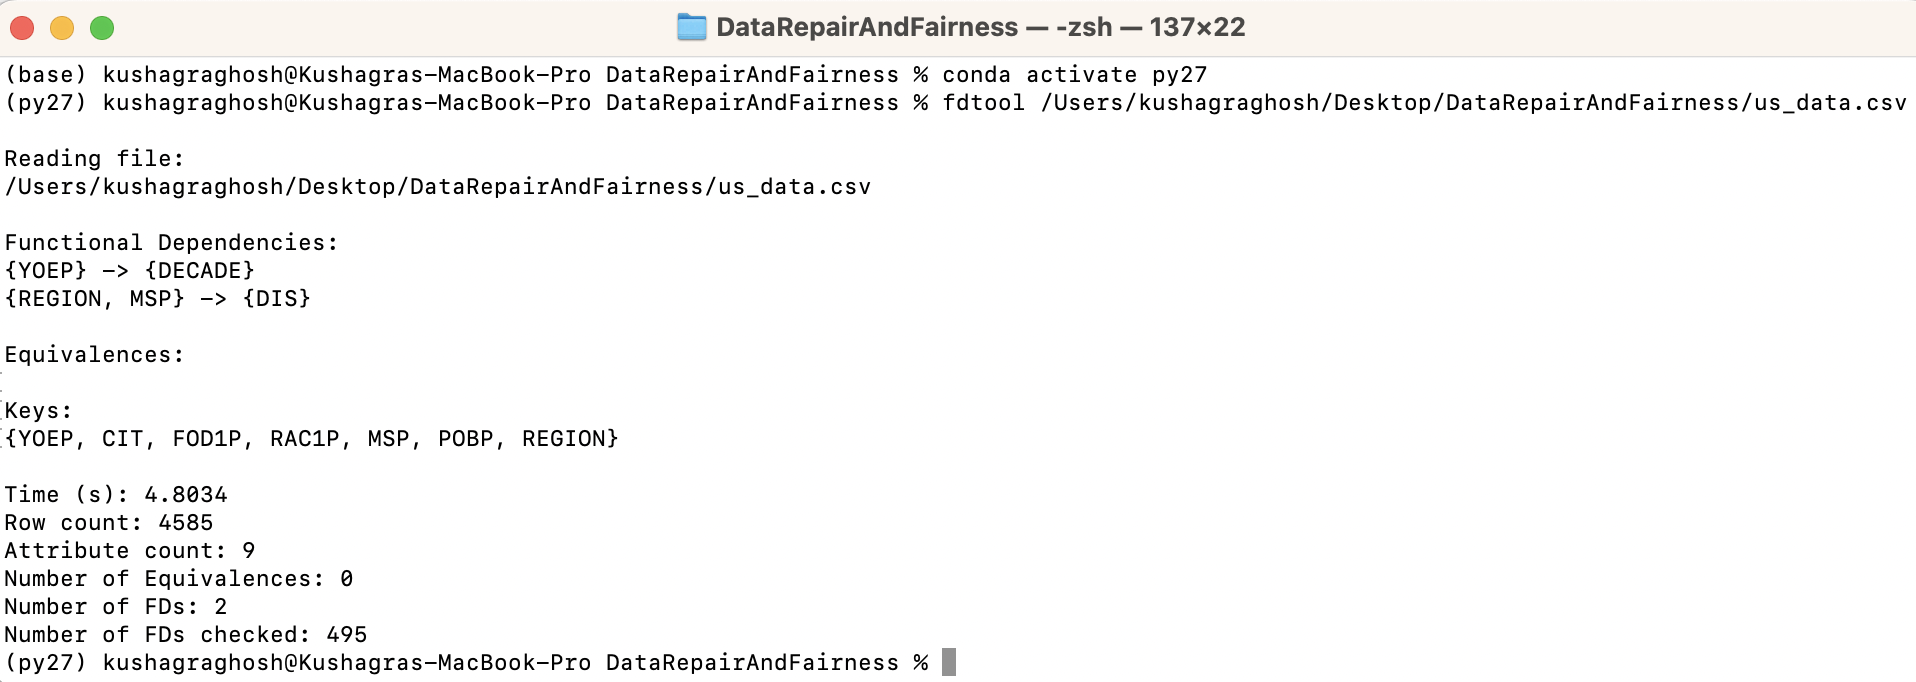

When I tried to add more columns to the FDTool to find functional dependencies, it said that table exceeds max column count, so I was only able to find a subset of functional dependencies to use for my synthetic data generator.

In [33]:
us_data.iloc[:,0:27].to_csv('us_data.csv',index=False)

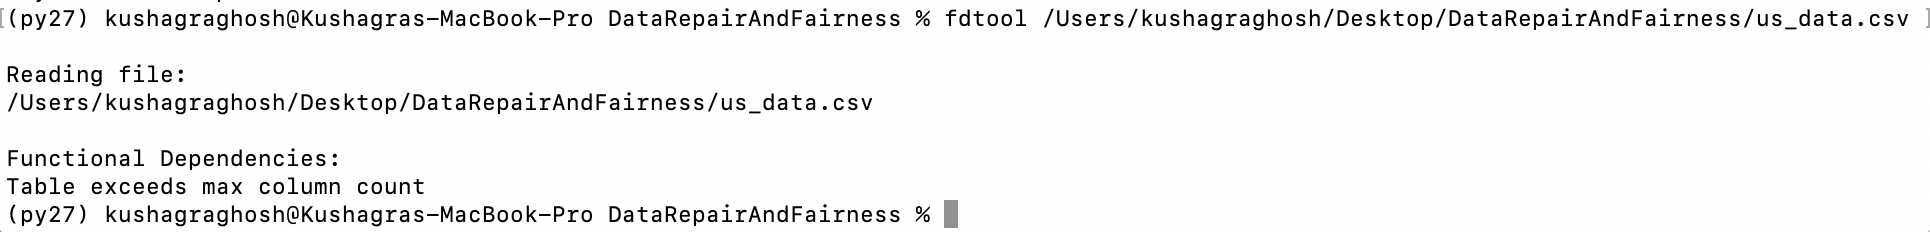

I used FixedCombinations as a proxy for functional dependencies since FixedCombinations were one of the only constraints that the Synthetic Data Vault (SDV) generators take in that is closest to a FD (since they didn't have a way to explicitly define FDs).

In [34]:
from sdv.constraints import FixedCombinations

fd = [['ST', 'REGION'], ['YOEP', 'DECADE'], ['REGION','MSP','DIS']]
denial_1 = FixedCombinations(column_names=fd[0])
denial_2 = FixedCombinations(column_names=fd[1])
denial_3 = FixedCombinations(column_names=fd[2])

metadata2 = metadata.copy()
metadata2['constraints'].append(denial_1)
metadata2['constraints'].append(denial_2)
metadata2['constraints'].append(denial_3)

with open('synthetic_constraints.txt', 'w') as f:
    for i in fd:
        if len(i) == 3:
            line = f"t1&t2&EQ(t1.{i[0]},t2.{i[0]})&EQ(t1.{i[1]},t2.{i[1]})&IQ(t1.{i[2]},t2.{i[2]})"
        else:
            line = f"t1&t2&EQ(t1.{i[0]},t2.{i[0]})&IQ(t1.{i[1]},t2.{i[1]})"
        f.write(line + "\n")

In [36]:
model2 = TabularPreset(name='FAST_ML', metadata=metadata2)
model2.fit(us_data)

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: FixedCombinations cannot be transformed because columns: ['REGION'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: FixedCombinations cannot be transformed because columns: ['REGION'] were not found. Using the reject sampling approach instead.
  warnings.warn(


In [37]:
new_data2 = model2.sample(num_rows=us_data.shape[0])
display(new_data2)

Sampling rows: 100%|█████████████████████| 32755/32755 [00:54<00:00, 598.40it/s]


,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,a,9,3,5500,3,51,1029928,183,28,...,261,204,284,110,125,280,205,206,152,283
1,P,b,4,2,3201,2,17,1029928,1,36,...,27,8,0,0,75,1,0,0,-3,-9
2,P,c,3,2,1002,4,8,1029928,164,34,...,169,184,185,164,92,272,103,8,316,89
3,P,d,1,4,802,4,56,1029928,215,30,...,284,272,179,251,55,200,204,229,156,167
4,P,e,7,3,10200,2,17,1029928,3,34,...,0,5,32,0,74,0,56,147,2,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32750,P,leQ,9,3,4638,1,42,1029928,19,25,...,44,107,60,0,40,92,0,0,-3,11
32751,P,leR,5,2,100,1,34,1029928,109,60,...,124,87,6,83,321,163,89,71,131,89
32752,P,leS,7,1,600,2,55,1029928,1,68,...,0,-4,0,0,-5,60,33,15,58,5
32753,P,leT,7,3,100,4,56,1029928,275,37,...,251,356,384,171,286,296,214,180,163,172


In [38]:
fd1_training = us_data.groupby(['ST'])['REGION'].nunique().eq(1).all()
fd1_new = new_data.groupby(['ST'])['REGION'].nunique().eq(1).all()
fd1_new2 = new_data2.groupby(['ST'])['REGION'].nunique().eq(1).all()
print("For the functional dependency between State -> US Region:")
print(f"The us_data original dataset satisfies FD: {fd1_training}\nThe generated synthetic data satisfies FD: {fd1_new}.\nThe synthetic data with constraints satisfies FD: {fd1_new2}.")

fd2_training = us_data.groupby(['YOEP'])['DECADE'].nunique().eq(1).all()
fd2_new = new_data.groupby(['YOEP'])['DECADE'].nunique().eq(1).all()
fd2_new2 = new_data2.groupby(['YOEP'])['DECADE'].nunique().eq(1).all()
print("\nFor the functional dependency between Year of Entry in US -> Decade of Entry in US:")
print(f"The us_data original dataset satisfies FD: {fd2_training}\nThe generated synthetic data satisfies FD: {fd2_new}.\nThe synthetic data with constraints satisfies FD: {fd2_new2}.")

For the functional dependency between State -> US Region:
The us_data original dataset satisfies FD: True
The generated synthetic data satisfies FD: False.
The synthetic data with constraints satisfies FD: True.

For the functional dependency between Year of Entry in US -> Decade of Entry in US:
The us_data original dataset satisfies FD: True
The generated synthetic data satisfies FD: False.
The synthetic data with constraints satisfies FD: True.


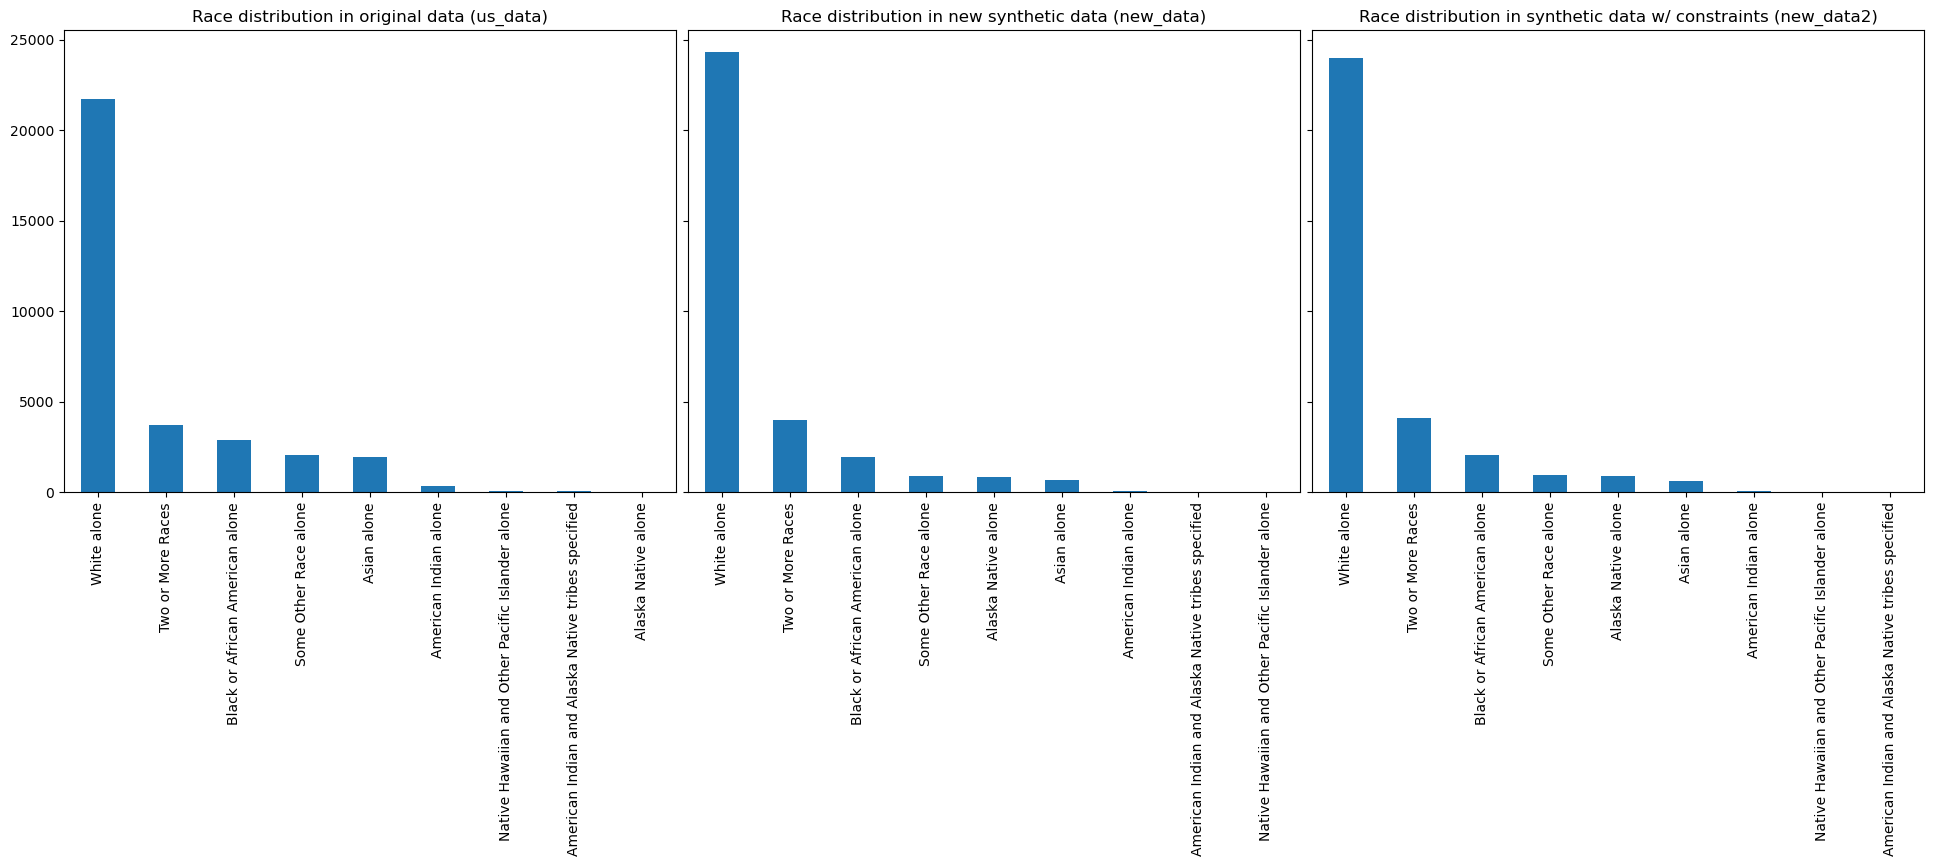

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(24,6), sharey=True)

us_data['RAC1P'].value_counts().plot.bar(ax=axs[0])
axs[0].set_xticks(range(len(race_labels)), [race_label_mapping[l] for l in race_labels])
axs[0].set_title("Race distribution in original data (us_data)")

new_data['RAC1P'].value_counts().plot.bar(ax=axs[1])
new_race_labels = new_data['RAC1P'].value_counts().keys()
axs[1].set_xticks(range(len(new_race_labels)), [race_label_mapping[l] for l in new_race_labels])
axs[1].set_title("Race distribution in new synthetic data (new_data)")

new_data2['RAC1P'].value_counts().plot.bar(ax=axs[2])
new_race_labels2 = new_data2['RAC1P'].value_counts().keys()
axs[2].set_xticks(range(len(new_race_labels)), [race_label_mapping[l] for l in new_race_labels2])
axs[2].set_title("Race distribution in synthetic data w/ constraints (new_data2)")

fig.subplots_adjust(wspace=0.02)
plt.show()

# print(us_data['RAC1P'].value_counts())
# print(new_data['RAC1P'].value_counts())
# print(new_data2['RAC1P'].value_counts())

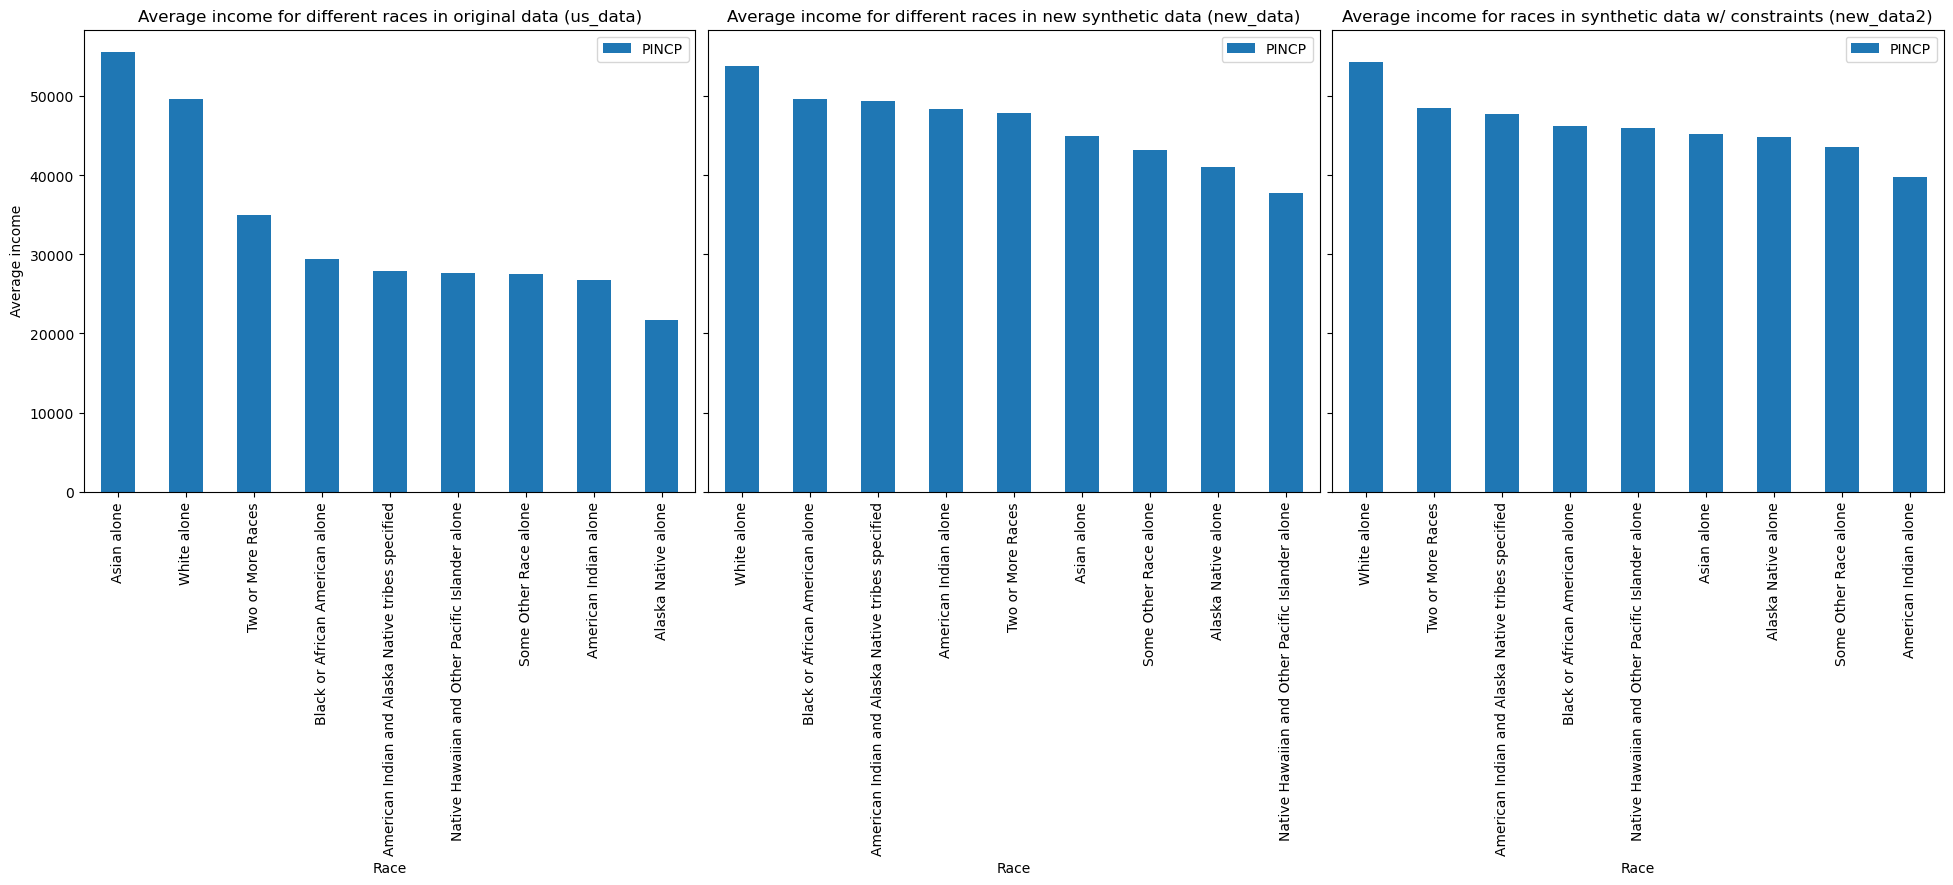

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(24,6), sharey=True)

race_income.plot.bar(ax=axs[0])
axs[0].set_xticks(range(len(race_labels)), [race_label_mapping[l] for l in race_income_labels])
axs[0].set_title("Average income for different races in original data (us_data)")
axs[0].set_xlabel("Race")
axs[0].set_ylabel("Average income")

race_income_new = new_data.pivot_table(values='PINCP', index='RAC1P', aggfunc='mean').sort_values(ascending=False, by='PINCP')
race_income_new_labels = list(race_income_new.index.values)
race_income_new.plot.bar(ax=axs[1])
axs[1].set_xticks(range(len(race_income_new_labels)), [race_label_mapping[l] for l in race_income_new_labels])
axs[1].set_title("Average income for different races in new synthetic data (new_data)")
axs[1].set_xlabel("Race")
axs[1].set_ylabel("Average income")

race_income_new2 = new_data2.pivot_table(values='PINCP', index='RAC1P', aggfunc='mean').sort_values(ascending=False, by='PINCP')
race_income_new_labels2 = list(race_income_new2.index.values)
race_income_new2.plot.bar(ax=axs[2])
axs[2].set_xticks(range(len(race_income_new_labels2)), [race_label_mapping[l] for l in race_income_new_labels2])
axs[2].set_title("Average income for races in synthetic data w/ constraints (new_data2)")
axs[2].set_xlabel("Race")
axs[2].set_ylabel("Average income")

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()

# print(race_label_mapping)
# print(race_income)
# print(race_income_new)
# print(race_income_new2)

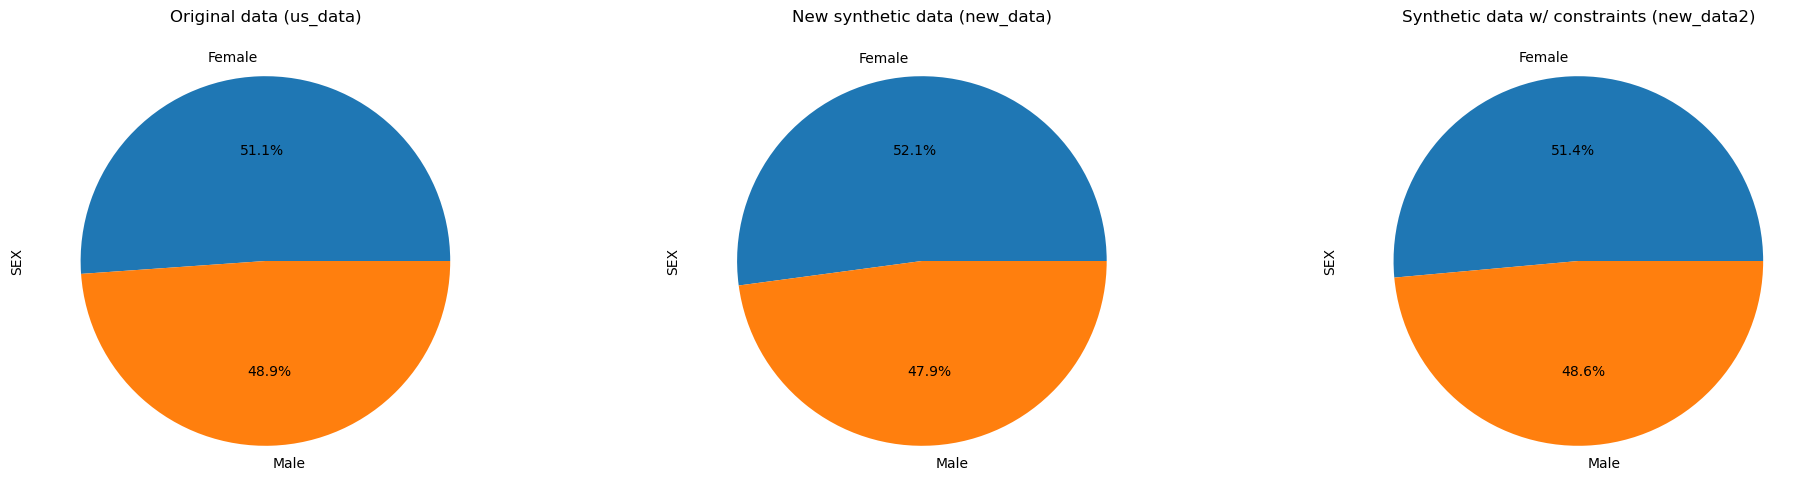

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(24,6))

original_sex_labels = us_data['SEX'].value_counts().keys()
us_data['SEX'].value_counts().plot(kind="pie", labels =[sex_label_mapping[l] for l in original_sex_labels], autopct='%1.1f%%', ax=axs[0])
axs[0].set_title("Original data (us_data)")

new_sex_labels = new_data['SEX'].value_counts().keys()
new_data['SEX'].value_counts().plot(kind="pie", labels =[sex_label_mapping[l] for l in new_sex_labels], autopct='%1.1f%%', ax=axs[1])
axs[1].set_title("New synthetic data (new_data)")

new_sex_labels2 = new_data2['SEX'].value_counts().keys()
new_data2['SEX'].value_counts().plot(kind="pie", labels =[sex_label_mapping[l] for l in new_sex_labels2], autopct='%1.1f%%', ax=axs[2])
axs[2].set_title("Synthetic data w/ constraints (new_data2)")

plt.show()

# print(us_data['SEX'].value_counts())
# print(new_data['SEX'].value_counts())
# print(new_data2['SEX'].value_counts())


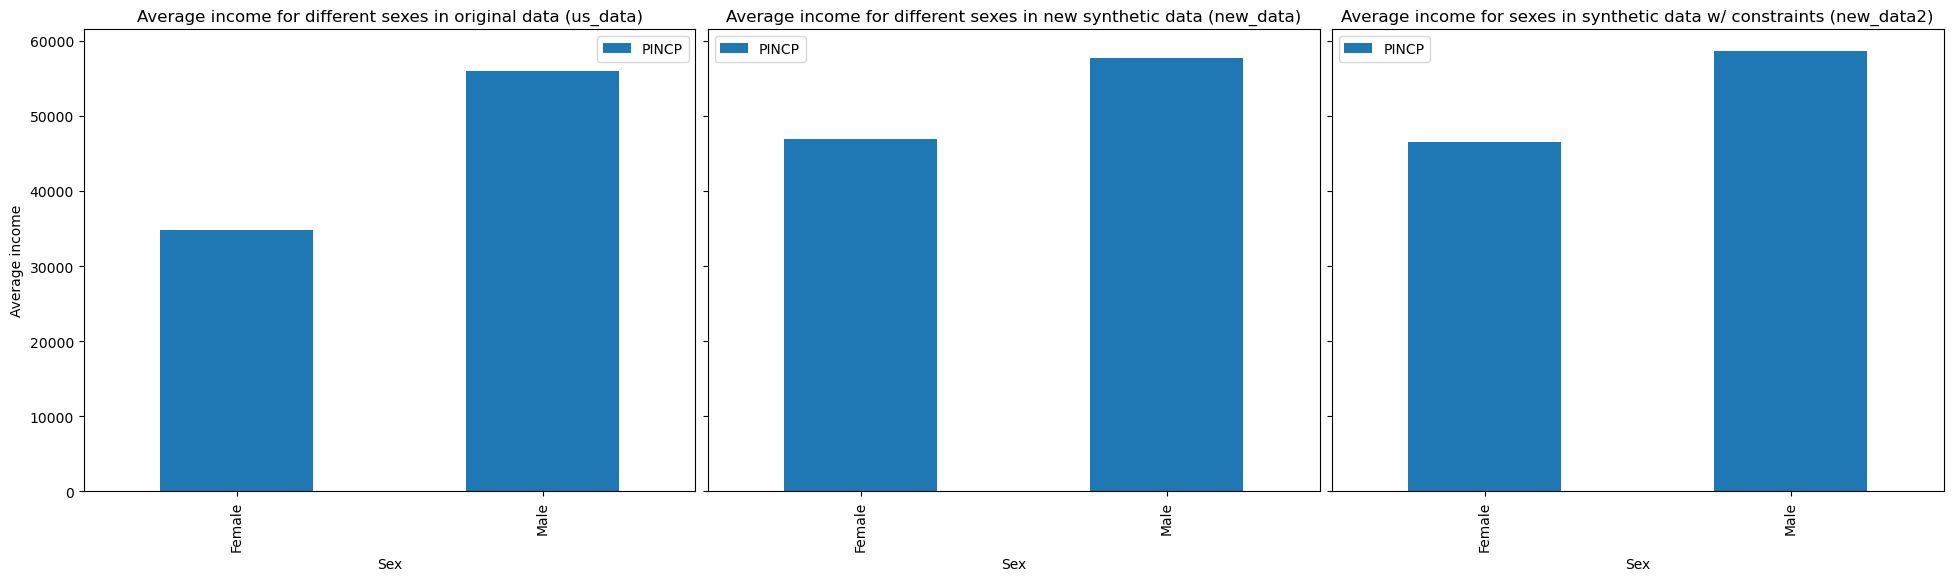

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(24,6), sharey=True)

sexes_income.plot.bar(ax=axs[0])
axs[0].set_xticks(range(len(sex_income_labels)), [sex_label_mapping[l] for l in sex_income_labels])
axs[0].set_title("Average income for different sexes in original data (us_data)")
axs[0].set_xlabel("Sex")
axs[0].set_ylabel("Average income")

sexes_income_new = new_data.pivot_table(values='PINCP', index='SEX', aggfunc='mean').sort_values(ascending=False, by='SEX')
new_sex_income_labels = list(sexes_income_new.index.values)
sexes_income_new.plot.bar(ax=axs[1])
axs[1].set_xticks(range(len(new_sex_income_labels)), [sex_label_mapping[l] for l in new_sex_income_labels])
axs[1].set_title("Average income for different sexes in new synthetic data (new_data)")
axs[1].set_xlabel("Sex")
axs[1].set_ylabel("Average income")

sexes_income_new2 = new_data2.pivot_table(values='PINCP', index='SEX', aggfunc='mean').sort_values(ascending=False, by='SEX')
new_sex_income_labels2 = list(sexes_income_new2.index.values)
sexes_income_new2.plot.bar(ax=axs[2])
axs[2].set_xticks(range(len(new_sex_income_labels2)), [sex_label_mapping[l] for l in new_sex_income_labels2])
axs[2].set_title("Average income for sexes in synthetic data w/ constraints (new_data2)")
axs[2].set_xlabel("Sex")
axs[2].set_ylabel("Average income")

plt.subplots_adjust(wspace=0.02)
plt.show()

# print(sex_label_mapping)
# print(sexes_income)
# print(sexes_income_new)
# print(sexes_income_new2)

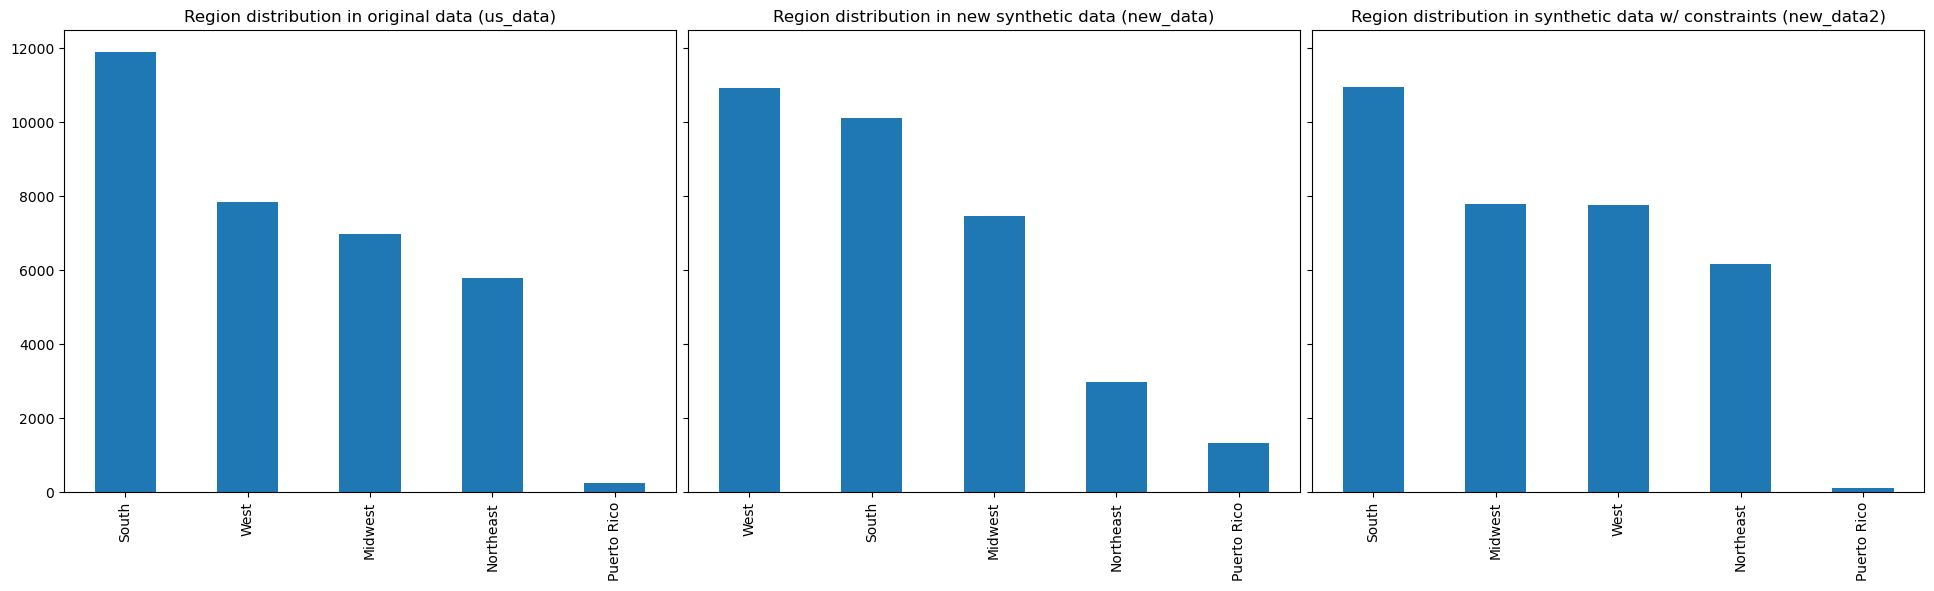

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(24,6), sharey=True)

us_data['REGION'].value_counts().plot.bar(ax=axs[0])
original_region_labels = us_data['REGION'].value_counts().keys()
axs[0].set_xticks(range(len(original_region_labels)), [region_label_mapping[l] for l in original_region_labels])
axs[0].set_title("Region distribution in original data (us_data)")

new_data['REGION'].value_counts().plot.bar(ax=axs[1])
new_region_labels = new_data['REGION'].value_counts().keys()
axs[1].set_xticks(range(len(new_region_labels)), [l if l not in region_label_mapping else region_label_mapping[l] for l in new_region_labels])
axs[1].set_title("Region distribution in new synthetic data (new_data)")

new_data2['REGION'].value_counts().plot.bar(ax=axs[2])
new_region_labels2 = new_data2['REGION'].value_counts().keys()
axs[2].set_xticks(range(len(new_region_labels)), [l if l not in region_label_mapping else region_label_mapping[l] for l in new_region_labels2])
axs[2].set_title("Region distribution in synthetic data w/ constraints (new_data2)")

plt.subplots_adjust(wspace=0.02)
plt.show()

# print(region_label_mapping)
# print(us_data['REGION'].value_counts())
# print(new_data['REGION'].value_counts())
# print(new_data2['REGION'].value_counts())


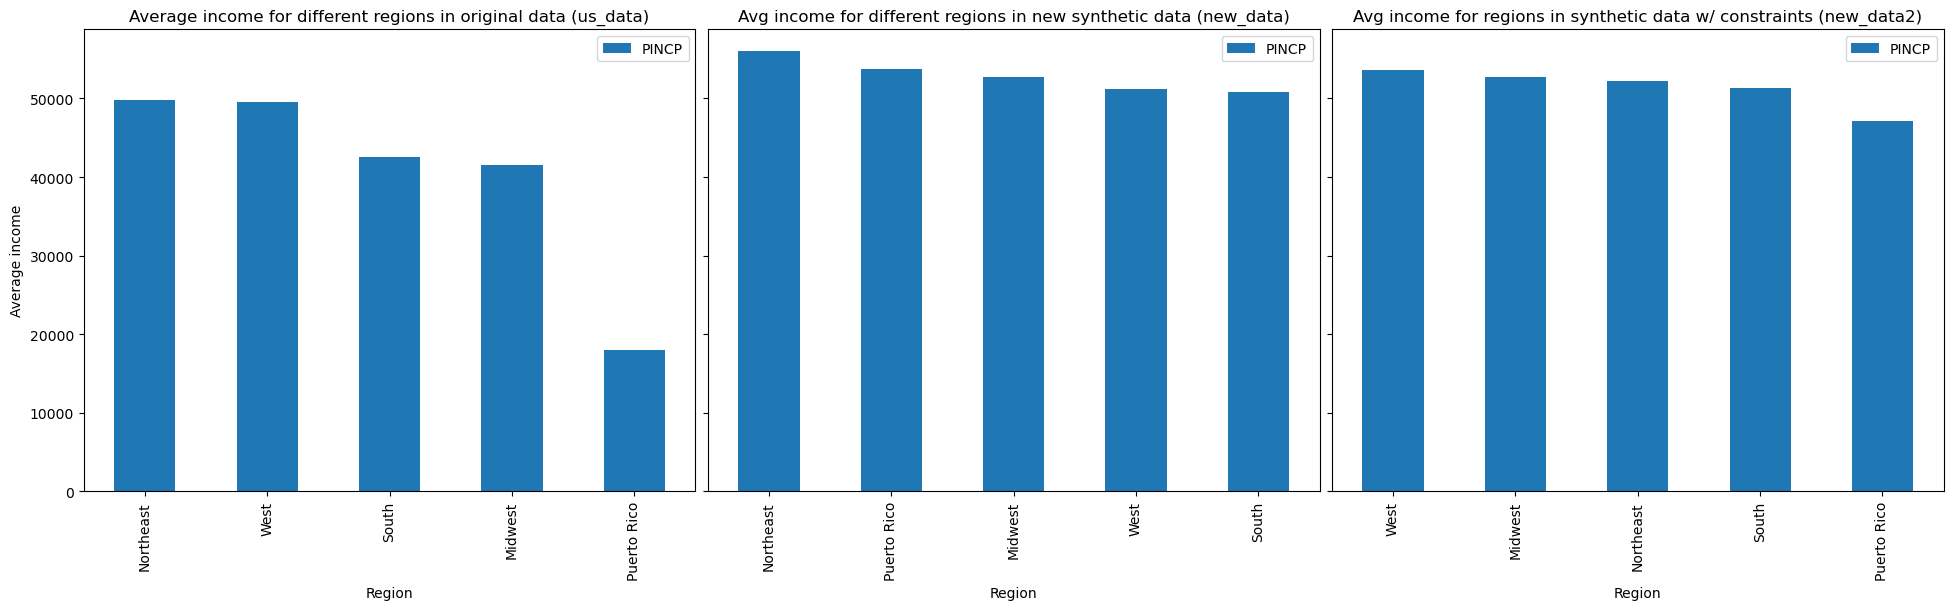

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(24,6), sharey=True)

region_income = us_data.pivot_table(values='PINCP', index='REGION', aggfunc='mean').sort_values(ascending=False, by='PINCP')
region_income_labels = list(region_income.index.values)
region_income.plot.bar(ax=axs[0])
axs[0].set_xticks(range(len(region_income_labels)), [region_label_mapping[l] for l in region_income_labels])
axs[0].set_title("Average income for different regions in original data (us_data)")
axs[0].set_xlabel("Region")
axs[0].set_ylabel("Average income")

region_income_new = new_data.pivot_table(values='PINCP', index='REGION', aggfunc='mean').sort_values(ascending=False, by='PINCP')
new_region_income_labels = list(region_income_new.index.values)
region_income_new.plot.bar(ax=axs[1])
axs[1].set_xticks(range(len(new_region_income_labels)), [l if l not in region_label_mapping else region_label_mapping[l] for l in new_region_income_labels])
axs[1].set_title("Avg income for different regions in new synthetic data (new_data)")
axs[1].set_xlabel("Region")
axs[1].set_ylabel("Average income")

region_income_new2 = new_data2.pivot_table(values='PINCP', index='REGION', aggfunc='mean').sort_values(ascending=False, by='PINCP')
new_region_income_labels2 = list(region_income_new2.index.values)
region_income_new2.plot.bar(ax=axs[2])
axs[2].set_xticks(range(len(new_region_income_labels)), [l if l not in region_label_mapping else region_label_mapping[l] for l in new_region_income_labels2])
axs[2].set_title("Avg income for regions in synthetic data w/ constraints (new_data2)")
axs[2].set_xlabel("Region")
axs[2].set_ylabel("Average income")

plt.subplots_adjust(wspace=0.02)
plt.show()

# print(region_label_mapping)
# print(region_income)
# print(region_income_new)
# print(region_income_new2)


In [48]:
new_data2.to_csv('synthetic.csv',index=False)

In [80]:
data_source.get_data(density=0.0001,download=True).iloc[:,:90].to_csv('us_data2.csv',index=False)

In [128]:
%%capture
pip install psycopg2

In [82]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe hospital_repaired
holoclean_data = pd.read_sql("SELECT * FROM us_data2_repaired", conn).iloc[:, 1:]

conn.close()

#Alternatively, access the new hospital data from the terminal in holoclean with:  1.   --user postgres     2. \c holo    3. \dt
#4. \copy (SELECT * FROM hospital_repaired) to '/Users/kushagraghosh/Desktop/DataRepairAndFairness/hospital_repaired.csv' with csv header;


/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [83]:
display(holoclean_data)

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,DECADE,DIS,DRIVESP,ESP,ESR,FOD1P,FOD2P,HICOV,HISP,INDP
0,p,2021hu0093181,6,3,400,3,1,1029928,187,31,...,1.0,2,1.0,1.0,1.0,1102.0,1301.0,1,1,1480.0
1,p,2021hu0523644,6,4,1900,3,1,1029928,94,10,...,8.0,2,1.0,2.0,1.0,1102.0,1301.0,1,1,1480.0
2,p,2021hu1387851,6,1,600,3,1,1029928,62,55,...,1.0,2,1.0,1.0,1.0,1102.0,1301.0,1,1,8770.0
3,p,2021hu0229021,8,2,113,4,4,1029928,66,62,...,6.0,2,1.0,1.0,6.0,6100.0,1301.0,1,2,180.0
4,p,2021hu0324859,8,1,107,4,4,1029928,53,71,...,1.0,2,1.0,1.0,6.0,6099.0,1301.0,1,1,7860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,p,2021hu1055254,3,2,100,2,55,1029928,14,63,...,1.0,2,1.0,1.0,1.0,1102.0,1301.0,1,1,5470.0
352,p,2021hu1247787,3,1,1001,2,55,1029928,68,45,...,1.0,2,1.0,1.0,1.0,1102.0,1301.0,1,1,7860.0
353,p,2021hu1377378,3,1,700,2,55,1029928,120,44,...,1.0,2,1.0,1.0,1.0,1102.0,1301.0,1,1,3070.0
354,p,2021hu0850324,0,2,1001,9,72,1029928,114,63,...,1.0,2,2.0,1.0,1.0,1102.0,1301.0,1,3,9290.0




---
I seperately checked if synthetic data generators (from SDV) preserve an arbitrary number of functional dependencies using the hospital dataset from https://github.com/HoloClean/holoclean/blob/master/testdata/hospital.csv. Besides having the original hospital dataset and synthetic dataset, I also created the cleaned dataset (from HoloClean) from my code in my HolocleanOnHospitalData.ipynb file.

In [52]:
url = "https://raw.githubusercontent.com/HoloClean/holoclean/master/testdata/hospital.csv"
hospital_data = pd.read_csv(url)
display(hospital_data.head())

,ProviderNumber,HospitalName,Address1,Address2,Address3,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,HospitalOwner,EmergencyService,Condition,MeasureCode,MeasureName,Score,Sample,Stateavg
0,10018,callahan eye foundation hospital,1720 university blvd,NaN,NaN,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-card-2,surgery patients who were taking heart drugs c...,NaN,NaN,al_scip-card-2
1,10018,callahan eye foundation hospital,1720 university blvd,NaN,NaN,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-1,surgery patients who were given an antibiotic ...,NaN,NaN,al_scip-inf-1
2,10018,callahan eye foundation hospital,1720 university blvd,NaN,NaN,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-2,surgery patients who were given the right kin...,NaN,NaN,al_scip-inf-2
3,10018,callahan eye foundation hospital,1720 university blvd,NaN,NaN,birminghxm,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-3,surgery patients whose preventive antibiotics ...,NaN,NaN,al_scip-inf-3
4,10018,callahan eye foundation hospital,1720 university blvd,NaN,NaN,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-4,all heart surgery patients whose blood sugar (...,NaN,NaN,al_scip-inf-4


I converted the denial constraints from https://github.com/HoloClean/holoclean/blob/master/testdata/hospital_constraints.txt to be FixedCombinations since these were one of the only type of constraints that the Synthetic Data Vault (SDV) generators take in. What I observed  was that the FixedCombinations constraints provided by the SDV generators does not allow for including one attribute in multiple constraints, which is a significant constraint. For example, the constraint between HospitalName and ZipCode, and with HospitalName and PhoneNumber, won't both be allowed since the attribute 'HospitalName' appears in both constraints.

In [53]:
from sdv.constraints import FixedCombinations

denial_1 = FixedCombinations(column_names=['Condition', 'MeasureName', 'HospitalType'])
denial_2 = FixedCombinations(column_names=['HospitalName', 'ZipCode'])
denial_3 = FixedCombinations(column_names=['HospitalName', 'PhoneNumber'])
denial_4 = FixedCombinations(column_names=['MeasureCode', 'MeasureName'])
denial_5 = FixedCombinations(column_names=['MeasureCode', 'Stateavg'])
denial_6 = FixedCombinations(column_names=['ProviderNumber', 'HospitalName'])
denial_7 = FixedCombinations(column_names=['MeasureCode', 'Condition'])
denial_8 = FixedCombinations(column_names=['HospitalName', 'Address1'])
denial_9 = FixedCombinations(column_names=['HospitalName', 'HospitalOwner'])
denial_10 = FixedCombinations(column_names=['HospitalName', 'ProviderNumber'])
denial_11 = FixedCombinations(column_names=['HospitalName', 'PhoneNumber', 'HospitalOwner', 'State'])
denial_12 = FixedCombinations(column_names=['City', 'CountyName'])
denial_13 = FixedCombinations(column_names=['ZipCode', 'EmergencyService'])
denial_14 = FixedCombinations(column_names=['HospitalName', 'City'])
denial_15 = FixedCombinations(column_names=['MeasureName', 'MeasureCode'])

#Denial Constraints 
# t1&t2&EQ(t1.Condition,t2.Condition)&EQ(t1.MeasureName,t2.MeasureName)&IQ(t1.HospitalType,t2.HospitalType) Condition,MeasureName ->  HospitalType
# t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.ZipCode,t2.ZipCode) HospitalName -> ZipCode
# t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.PhoneNumber,t2.PhoneNumber) HospitalName -> PhoneNumber
# t1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.MeasureName,t2.MeasureName)  MeasureCode -> MeasureName
# t1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.Stateavg,t2.Stateavg)   MeasureCode -> Stateavg
# t1&t2&EQ(t1.ProviderNumber,t2.ProviderNumber)&IQ(t1.HospitalName,t2.HospitalName) ProviderNumber -> HospitalName
# t1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.Condition,t2.Condition)  MeasureCode -> Condition
# t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.Address1,t2.Address1)  HospitalName -> Address1
# t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.HospitalOwner,t2.HospitalOwner) HospitalName -> HospitalOwner
# t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.ProviderNumber,t2.ProviderNumber) HospitalName -> ProviderNumber
# t1&t2&EQ(t1.HospitalName,t2.HospitalName)&EQ(t1.PhoneNumber,t2.PhoneNumber)&EQ(t1.HospitalOwner,t2.HospitalOwner)&IQ(t1.State,t2.State). HospitalName, PhoneNumber, HospitalOwner -> State
# t1&t2&EQ(t1.City,t2.City)&IQ(t1.CountyName,t2.CountyName) City -> CountyName
# t1&t2&EQ(t1.ZipCode,t2.ZipCode)&IQ(t1.EmergencyService,t2.EmergencyService) ZipCode -> EmergencyService
# t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.City,t2.City) HospitalName -> City
# t1&t2&EQ(t1.MeasureName,t2.MeasureName)&IQ(t1.MeasureCode,t2.MeasureCode) MeasureName -> MeasureCode

metadata = {
    'fields': {
        'ProviderNumber': {'type': 'categorical'},
        'HospitalName': {'type': 'categorical'},
        'Address1': {'type': 'categorical'},
        'Address2': {'type': 'categorical'},
        'Address3': {'type': 'categorical'},
        'City': {'type': 'categorical'},
        'State': {'type': 'categorical'},
        'ZipCode': {'type': 'categorical'},
        'CountyName': {'type': 'categorical'},
        'PhoneNumber': {'type': 'categorical'},
        'HospitalType': {'type': 'categorical'},
        'HospitalOwner': {'type': 'categorical'},
        'EmergencyService': {'type': 'boolean'},
        'Condition': {'type': 'categorical'},
        'MeasureCode': {'type': 'categorical'},
        'MeasureName': {'type': 'categorical'}, 
        'Score': {'type': 'categorical'}, 
        'Sample': {'type': 'categorical'}, 
        'Stateavg': {'type': 'categorical'}
    },
    'constraints': [denial_1, denial_3]
    # 'constraints': [denial_1, denial_2, denial_3, denial_4, denial_5, denial_6, denial_7, denial_8, denial_9, denial_10, denial_11, denial_12, denial_13, denial_14, denial_15],
}

As we can see from these denial constraints, the SDV synthetic data generators can handle multiple conditions, but the attributes in each constraint has to be distinct or it throws an error. 

Next, I will create a synthetic hospital dataset with SDV TabularPreset with the hospital data constraints above. I inputed the fixed combinations (which came from the denial constraints of the hospital data) into the TabularPreset SDV model in order to generate new synthetic ASC person data. 

In [54]:
hospital_model = TabularPreset(name='FAST_ML', metadata = metadata)
hospital_model.fit(hospital_data)

In [55]:
new_hospital_data = hospital_model.sample(num_rows=hospital_data.shape[0])
display(new_hospital_data)

Sampling rows: 100%|██████████████████████| 1000/1000 [00:00<00:00, 6882.50it/s]


,ProviderNumber,HospitalName,Address1,Address2,Address3,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,HospitalOwner,EmergencyService,Condition,MeasureCode,MeasureName,Score,Sample,Stateavg
0,10022,chilton medical center,1720 university blvd,NaN,NaN,opp,al,35233,jefferson,2057552500,acute care hospitals,voluntary non-profit - private,False,surgical infection prevention,scip-inf-2,surgery pxtients who were txking hexrt drugs c...,87%,34 patients,al_pn-7
1,10046,dekalb regional medical center,400 northwood dr,NaN,NaN,birmingham,al,35233,montgomery,2568453150,acute care hospitals,government - hospital district or authority,False,heart attack,hf-1,heart attack patients given ace inhibitor or a...,99%,123 patients,al_scip-inf-3
2,10027,jackson hospital & clinic inc,150 gilxreath drive,NaN,NaN,huntsville,al,3xx94,jefferson,3342938000,acute care hospitals,voluntary non-profit - private,False,pneumonia,pnx6,pneumonia patients assessed and given influenz...,NaN,117 patients,al_pn-5c
3,10039,shelby baptist medical center,1725 pine street,NaN,NaN,winfield,al,35660,chilton,2056208100,acute care hospitals,government - hospital district or authority,False,pneumonia,scip-vte-2,pneumonia patients assessed and given pneumoco...,NaN,129 patients,al_scip-inf-6
4,10029,gadsden regional medical center,126 hospital ave,NaN,NaN,andalusia,al,3590x,cxffee,2564944000,acute care hospitals,government - hospital district or authority,False,pneumonia,scip-inf-1,pneumonia patients given initial antibiotic(s)...,100%,1 patients,al_ami-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10009,hartselle medical center,200 med center drive,NaN,NaN,alabaster,al,36467,jefferson,2567736511,acute care hospitals,government - hospital district or authority,False,heart failure,ami-8a,heart failure patients given discharge instruc...,96%,10 patients,al_ami-5
996,10043,st vincents east,101 hospital circle,NaN,NaN,georgiana,al,36323,clarke,2058383122,acute care hospitals,government - hospital district or authority,False,pneumonia,ami-4,pneumonia patients given initial antibiotic(s)...,100%,350 patients,al_pn-7
997,10006,dekalb regional medical center,1653 temple avenue north,NaN,NaN,thomasville,al,35570,shelby,2568453150,acute care hospitals,voluntary non-profit - private,False,surgical infection prevention,pn-3b,patients who got treatment at the right time ...,78%,159 patients,al_scip-inf-3
998,10023,gadsden regional medical center,126 hospital ave,NaN,NaN,alabaster,al,36278,montgomery,2564944000,acute care hospitals,voluntary non-profit - private,False,heart failure,pn-5c,heart failure patients given smoking cessation...,NaN,24 patients,al_hf-2


In [56]:
hospital_fd1 = hospital_data.groupby(['HospitalName'])['ZipCode'].nunique().eq(1).all()
hospital_fd2 = hospital_data.groupby(['MeasureCode'])['MeasureName'].nunique().eq(1).all()
new_hospital_fd1 = new_hospital_data.groupby(['HospitalName'])['ZipCode'].nunique().eq(1).all()
new_hospital_fd2 = new_hospital_data.groupby(['MeasureCode'])['MeasureName'].nunique().eq(1).all()
print(f"For the functional dependency between HospitalName -> ZipCode: The hospital dataset satisfies FD: {hospital_fd1}. The synthetic hospital dataset satisfies FD: {new_hospital_fd1}.")
print(f"For the functional dependency between MeasureCode -> MeasureName: The hospital dataset satisfies FD: {hospital_fd2}. The synthetic hospital dataset satisfies FD: {new_hospital_fd2}.")

For the functional dependency between HospitalName -> ZipCode: The hospital dataset satisfies FD: False. The synthetic hospital dataset satisfies FD: False.
For the functional dependency between MeasureCode -> MeasureName: The hospital dataset satisfies FD: False. The synthetic hospital dataset satisfies FD: False.


If the original hospital dataset is noisy, then the SDV synthetic data generator only allowed for selecting FixedCombinations of those attributes, so there will be combinations of those noisy combinations and the synthetic data will also be noisy.

In [57]:
hospital_data.to_csv('hospital.csv',index=False)

Once we have the synthetic data in a CSV, we can run the HolocleanOnHospitalData notebook to go from the synthetic hospital data to the cleaned synthetic hospital data. Afterwards, we can access and download the new hospital data in holoclean with psycopg2.

In [34]:
%%capture
pip install psycopg2

In [35]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe hospital_repaired
hospital_repaired = pd.read_sql("SELECT * FROM hospital_repaired", conn).iloc[:, 1:]

conn.close()

#Alternatively, access the new hospital data from the terminal in holoclean with:  1.   --user postgres     2. \c holo    3. \dt
#4. \copy (SELECT * FROM hospital_repaired) to '/Users/kushagraghosh/Desktop/DataRepairAndFairness/hospital_repaired.csv' with csv header;


/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


To check how many tuples were changed using the HoloClean repair process on the original hospital data:

In [132]:
print(hospital_repaired.columns)
hospital_data_withoutAddress2and3 = hospital_data.iloc[:, list(range(3)) + list(range(5, len(hospital_data.columns)))]
hospital_repaired = hospital_repaired.replace('_nan_', np.nan)

comparing_hospital = hospital_data_withoutAddress2and3.compare(hospital_repaired)
display(comparing_hospital)

print(f"{comparing_hospital.isna().eq(False).sum().sum()/2} cells were changed")
print(f"{comparing_hospital.shape[0]} tuples out of a total {hospital_data_withoutAddress2and3.shape[0]} were changed")

Index(['ProviderNumber', 'HospitalName', 'Address1', 'City', 'State',
       'ZipCode', 'CountyName', 'PhoneNumber', 'HospitalType', 'HospitalOwner',
       'EmergencyService', 'Condition', 'MeasureCode', 'MeasureName', 'Score',
       'Sample', 'Stateavg'],
      dtype='object')


ProviderNumber        HospitalName                   Address1  \
              self  other         self other                 self   
3              NaN    NaN          NaN   NaN                  NaN   
7              NaN    NaN          NaN   NaN                  NaN   
10             NaN    NaN          NaN   NaN                  NaN   
13           1xx19  10019          NaN   NaN                  NaN   
16             NaN    NaN          NaN   NaN                  NaN   
..             ...    ...          ...   ...                  ...   
966            NaN    NaN          NaN   NaN                  NaN   
968            NaN    NaN          NaN   NaN                  NaN   
976            NaN    NaN          NaN   NaN                  NaN   
985            NaN    NaN          NaN   NaN                  NaN   
986            NaN    NaN          NaN   NaN  150 gilxreath drive   

                                City             State        ... MeasureCode  \
                   other        self       other  self other  ...        self   
3                    NaN  birminghxm  birmingham   NaN   NaN  ...         NaN   
7                    NaN  birmingxam  birmingham   NaN   NaN  ...         NaN   
10                   NaN   sheffxeld   sheffield   NaN   NaN  ...         NaN   
13                   NaN         NaN         NaN   NaN   NaN  ...         NaN   
16                   NaN         NaN         NaN   NaN   NaN  ...         NaN   
..                   ...         ...         ...   ...   ...  ...         ...   
966                  NaN         NaN         NaN   NaN   NaN  ...         NaN   
968                  NaN  xntxrprisx  enterprise   NaN   NaN  ...         NaN   
976                  NaN         NaN         NaN   NaN   NaN  ...         NaN   
985                  NaN     onxonta     oneonta   NaN   NaN  ...         NaN   
986  150 gilbreath drive         NaN         NaN   NaN   NaN  ...         NaN   

          MeasureName       Score       Sample       Stateavg        
    other        self other  self other   self other     self other  
3     NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
7     NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
10    NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
13    NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
16    NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
..    ...         ...   ...   ...   ...    ...   ...      ...   ...  
966   NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
968   NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
976   NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
985   NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  
986   NaN         NaN   NaN   NaN   NaN    NaN   NaN      NaN   NaN  

[521 rows x 34 columns]

2465.0 cells were changed
521 tuples out of a total 1000 were changed


To check how well 2 functional dependencies (HospitalName -> ZipCode and MeasureCode -> MeasureName) function in the original hospital data, the synthetic hospital data with those 2 FD constraints from above, and the repaired HoloClean data: 

In [65]:
hospital_fd1 = hospital_data.groupby(['HospitalName'])['ZipCode'].value_counts().get(0, 0)
hospital_fd2 = hospital_data.groupby(['MeasureCode'])['MeasureName'].value_counts().get(0, 0)
new_hospital_fd1 = new_hospital_data.groupby(['HospitalName'])['ZipCode'].value_counts().get(0, 0)
new_hospital_fd2 = new_hospital_data.groupby(['MeasureCode'])['MeasureName'].value_counts().get(0, 0)
hospital_repaired_fd1 = hospital_repaired.groupby(['HospitalName'])['ZipCode'].value_counts().get(0, 0)
hospital_repaired_fd2 = hospital_repaired.groupby(['MeasureCode'])['MeasureName'].value_counts().get(0, 0)
print(f"For the functional dependency between HospitalName -> ZipCode: \nThe hospital dataset breaks the functional dependency for {hospital_fd1} groups of hospitals. \nThe synthetic hospital dataset breaks the functional dependency for {new_hospital_fd1} groups of hospitals.")
print(f"The repaired hospital dataset breaks the functional dependency for {hospital_repaired_fd1} hospitals.")
print(f"\nFor the functional dependency between MeasureCode -> MeasureName: \nThe hospital dataset breaks the functional dependency for {hospital_fd2} groups of MeasureCode. \nThe synthetic hospital dataset breaks the functional dependency for {new_hospital_fd2} groups of MeasureCode.")
print(f"The repaired hospital dataset breaks the functional dependency for {hospital_repaired_fd2} groups of MeasureCode.")


For the functional dependency between HospitalName -> ZipCode: 
The hospital dataset breaks the functional dependency for 17 groups of hospitals. 
The synthetic hospital dataset breaks the functional dependency for 1 groups of hospitals.
The repaired hospital dataset breaks the functional dependency for 17 hospitals.

For the functional dependency between MeasureCode -> MeasureName: 
The hospital dataset breaks the functional dependency for 33 groups of MeasureCode. 
The synthetic hospital dataset breaks the functional dependency for 5 groups of MeasureCode.
The repaired hospital dataset breaks the functional dependency for 33 groups of MeasureCode.


Based on the original hospital dataset's performance on the functional dependency, we can determine that there are noisy data in the original hospital data that is preserved in the HoloClean repaired dataset. We see an example of this in the HospitalName -> ZipCode functional dependency: 

In [137]:
hospital_names = hospital_data.groupby(['HospitalName'])['ZipCode'].nunique()[hospital_data.groupby(['HospitalName'])['ZipCode'].nunique()>1]
print(f"{hospital_names.count()} hospitals that don't conform to the HospitalName -> ZipCode FDs:\n{hospital_names}\n\nThe {hospital_data[hospital_data['HospitalName'].isin(hospital_names.index)].shape[0]} tuples that don't conform to the HospitalName -> ZipCode functional dependency: ")

display(hospital_data[hospital_data['HospitalName'].isin(hospital_names.index)])


20 hospitals that don't conform to the HospitalName -> ZipCode FDs:
HospitalName
andalusia regional hospital          2
cherokee medical center              2
coosa valley medical center          3
crenshaw community hospital          3
dale medical center                  2
dekalb regional medical center       2
eliza coffee memorial hospital       2
flowers hospital                     3
gadsden regional medical center      2
hartselle medical center             2
jackson hospital & clinic inc        2
marshall medical center south        3
northwest medical center             2
prattville baptist hospital          2
riverview regional medical center    2
shelby baptist medical center        3
southwest alabama medical center     2
st vincents east                     2
stringfellow memorial hospital       2
university of alabama hospital       3
Name: ZipCode, dtype: int64

The 477 tuples that don't conform to the HospitalName -> ZipCode functional dependency: 


,ProviderNumber,HospitalName,Address1,Address2,Address3,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,HospitalOwner,EmergencyService,Condition,MeasureCode,MeasureName,Score,Sample,Stateavg
44,10005,marshall medical center south,2505 u s highway 431 north,NaN,NaN,boaz,al,x5957,marshall,2565938310,acute care hospitals,government - hospital district or authority,yes,heart attack,ami-1,heart attack patients given aspirin at arrival,80%,20 patients,al_ami-1
45,x0005,marshall medical center south,2505 u s highway 431 north,NaN,NaN,boaz,al,35957,marshall,2565938310,acute care hospitals,government - hospital district or authority,yes,heart attack,ami-2,heart attack patients given aspirin at discharge,60%,5 patients,al_ami-2
46,10005,marshall medical center south,2505 u s highway 431 north,NaN,NaN,boaz,xl,35957,marshall,2565938310,acute care hospitals,government - hospital district or authority,yes,heart attack,ami-3,heart attack patients given ace inhibitor or a...,100%,2 patients,al_ami-3
47,10005,marshall medical center south,2505 u s highway 431 north,NaN,NaN,boaz,al,35957,marshall,2565938310,acute care hospitals,government - hospital district or authority,yes,heart attack,ami-4,heart attack patients given smoking cessation ...,NaN,0 patients,al_ami-4
48,10005,marshall medical center south,2505 u s highway 431 north,NaN,NaN,boaz,al,35957,marshall,2565938310,acute care hospitals,government - hospital district or authority,yes,heart attack,ami-5,heart attack patients given beta blocker at di...,100%,5 patients,al_ami-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,10046,riverview regional medical center,600 south third street,NaN,NaN,gadsden,al,35901,etowah,2565435200,acute care hospitals,proprietary,yes,surgical infection prevention,scip-inf-3,surgery patients whose preventive antibiotics ...,79%,352 patients,al_scip-inf-3
926,10046,riverview regional medical center,600 south third street,NaN,NaN,gadsden,al,35901,etowah,2565435200,acuxe care hospixals,proprietary,yes,surgical infection prevention,scip-inf-4,all heart surgery patients whose blood sugar (...,76%,114 patients,al_scip-inf-4
927,10046,riverview regional medical center,600 south third street,NaN,NaN,gadsden,al,35901,etowah,2565435200,acute care hospitals,proprietary,yes,surgical infection prevention,scip-inf-6,surgery patients needing hair removed from the...,100%,607 patients,al_scip-inf-6
928,10046,riverview regional medical center,600 south third street,NaN,NaN,gadsden,al,35901,etowah,2565435200,acute care hospitals,proprietary,yes,surgical infection prevention,scip-vte-1,surgery patients whose doctors ordered treatme...,91%,280 patients,al_scip-vte-1
